In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from pathlib import Path
import os
import re
from typing import Dict, Tuple, Optional

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def smooth_curve(x, y, window_size=5):
    """
    Smooth a curve using moving average (window averaging).
    
    window_size parameter (adjust for smoothness):
    - 3: Minimal smoothing (less averaging)
    - 5: Default (moderate smoothing)
    - 7-9: More smoothing
    - 11+: Heavy smoothing (very smooth)
    
    Larger window = smoother curve
    """
    if len(y) < window_size:
        return x, y
    
    try:
        # Apply moving average with centered window
        kernel = np.ones(window_size) / window_size
        # Pad the data for better edge handling
        y_padded = np.pad(y, (window_size//2, window_size//2), mode='edge')
        y_smooth = np.convolve(y_padded, kernel, mode='valid')
        
        return x, y_smooth
    except:
        return x, y

def find_seed_paths(base_pattern):
    """
    Find all seed directories matching the pattern.
    Returns a list of (seed_number, path) tuples sorted by seed.
    """
    base_dir = Path(base_pattern).parent
    pattern_name = Path(base_pattern).name
    
    # Convert glob pattern to regex
    regex_pattern = pattern_name.replace('*', '\\d+')
    regex = re.compile(f"^{regex_pattern}$")
    
    seed_paths = []
    
    if base_dir.exists():
        for item in base_dir.iterdir():
            if item.is_dir() and regex.match(item.name):
                # Extract seed number from directory name
                seed_match = re.search(r'(\d+)$', item.name)
                if seed_match:
                    seed_num = int(seed_match.group(1))
                    seed_paths.append((seed_num, item))
    
    # Sort by seed number
    seed_paths.sort(key=lambda x: x[0])
    return seed_paths

def find_metrics_file(seed_dir):
    """
    Find metrics.jsonl file in seed directory.
    Looks for metrics.jsonl in the directory or its subdirectories.
    """
    seed_path = Path(seed_dir)
    
    # Try direct metrics.jsonl
    direct_path = seed_path / 'metrics.jsonl'
    if direct_path.exists():
        return direct_path
    
    # Try searching in subdirectories
    for metrics_file in seed_path.rglob('metrics.jsonl'):
        return metrics_file
    
    return None

def aggregate_eval_metrics(jsonl_file, experiment_name, seed_num, remove_lowest=False):
    """
    Read JSONL file and aggregate eval scores into average and variance.
    
    Args:
        jsonl_file: Path to the metrics.jsonl file
        experiment_name: Name of the experiment
        seed_num: Seed number
        remove_lowest: If True, remove the lowest eval score from each step before aggregating
    
    Returns:
        DataFrame with aggregated metrics, or None if no valid data
    """
    print(f"  Processing seed {seed_num}..." + (" (removing lowest score)" if remove_lowest else ""))
    
    # Load all data
    data = []
    try:
        with open(jsonl_file, 'r') as f:
            for line in f:
                if line.strip():
                    data.append(json.loads(line))
    except FileNotFoundError:
        print(f"    ❌ File not found: {jsonl_file}")
        return None
    
    # Extract eval records
    eval_records = [d for d in data if 'eval_return' in d]
    
    if not eval_records:
        print(f"    ❌ No eval records found")
        return None
    
    # Group eval records by step
    eval_by_step = defaultdict(list)
    for record in eval_records:
        step = record['step']
        eval_by_step[step].append(record)
    
    # Create aggregated dataset
    aggregated_data = []
    
    for step, eval_list in sorted(eval_by_step.items()):
        eval_returns = [e['eval_return'] for e in eval_list]
        
        # If remove_lowest is True and we have at least 2 evals, remove the lowest
        if remove_lowest and len(eval_returns) >= 2:
            min_idx = eval_returns.index(min(eval_returns))
            removed_lowest_score = min(eval_returns)
            eval_returns_filtered = [e for i, e in enumerate(eval_returns) if i != min_idx]
            num_evals_used = len(eval_returns_filtered)
        else:
            eval_returns_filtered = eval_returns
            removed_lowest_score = None
            num_evals_used = len(eval_returns)
        
        # Calculate mean and variance on (possibly filtered) scores
        avg_eval_return = np.mean(eval_returns_filtered)
        var_eval_return = np.var(eval_returns_filtered, ddof=1) if len(eval_returns_filtered) > 1 else 0
        
        aggregated_record = {
            'step': step,
            'avg_eval_return': avg_eval_return,
            'var_eval_return': var_eval_return,
            'num_evals_used': num_evals_used,
            'seed': seed_num
        }
        
        # Only add removed_lowest_score to record if it was actually removed
        if remove_lowest and removed_lowest_score is not None:
            aggregated_record['removed_lowest_score'] = removed_lowest_score
        
        aggregated_data.append(aggregated_record)
    
    print(f"    ✓ Processed {len(aggregated_data)} evaluation steps")
    
    return pd.DataFrame(aggregated_data)

# ============================================================================
# MAIN ANALYSIS FUNCTION
# ============================================================================

def analyze_metrics(experiment_paths: Dict[str, str], 
                   output_dir: str = 'results',
                   smoothness: int = 5,
                   remove_lowest: bool = False) -> Dict[str, pd.DataFrame]:
    """
    Comprehensive metrics analysis pipeline.
    
    Args:
        experiment_paths: Dictionary mapping experiment names to path patterns
                         e.g., {'MoE': "/path/to/moe_seed*", 'Original': "/path/to/logs_seed*"}
        output_dir: Directory to save results (default: 'results')
        smoothness: Window size for moving average smoothing (default: 5)
                   - 3: Minimal smoothing
                   - 5: Default (moderate smoothing)
                   - 7-9: More smoothing
                   - 11+: Heavy smoothing
        remove_lowest: If True, remove lowest eval score per step (default: False)
    
    Returns:
        Dictionary of aggregated results {exp_name: aggregated_df}
    """
    
    print("="*70)
    print("MULTI-SEED EVALUATION METRICS AGGREGATOR")
    print("="*70)
    print(f"Mode: {'REMOVE LOWEST SCORE' if remove_lowest else 'KEEP ALL SCORES'}")
    print(f"Smoothness: {smoothness}")
    print("="*70)
    
    # Process all experiment categories and their seeds
    all_results = {}  # {exp_name: {seed: df, ...}, ...}
    
    for exp_name, base_pattern in experiment_paths.items():
        print(f"\n📊 Processing experiment: {exp_name}")
        print(f"   Pattern: {base_pattern}")
        
        seed_paths = find_seed_paths(base_pattern)
        
        if not seed_paths:
            print(f"   ⚠️  No seed directories found matching pattern!")
            continue
        
        print(f"   ✓ Found {len(seed_paths)} seed(s): {[s[0] for s in seed_paths]}")
        
        experiment_results = {}
        
        for seed_num, seed_dir in seed_paths:
            metrics_file = find_metrics_file(seed_dir)
            
            if metrics_file is None:
                print(f"  ❌ No metrics.jsonl found in {seed_dir}")
                continue
            
            df = aggregate_eval_metrics(metrics_file, exp_name, seed_num, remove_lowest=remove_lowest)
            
            if df is not None:
                experiment_results[seed_num] = df
        
        if experiment_results:
            all_results[exp_name] = experiment_results
            print(f"   ✓ Successfully processed {len(experiment_results)} seed(s)")
        else:
            print(f"   ❌ No valid seeds for {exp_name}")
    
    if not all_results:
        print("\n❌ No valid experiments to process!")
        return {}
    
    print(f"\n{'='*70}")
    print(f"✓ Successfully processed all experiments")
    print(f"{'='*70}\n")
    
    # ========================================================================
    # AGGREGATE ACROSS SEEDS FOR EACH EXPERIMENT
    # ========================================================================
    
    print("Aggregating metrics across seeds...\n")
    
    cross_seed_results = {}  # {exp_name: df_aggregated}
    
    for exp_name, seed_results in all_results.items():
        print(f"{exp_name}:")
        
        # Combine all seed data
        all_seed_dfs = list(seed_results.values())
        combined_df = pd.concat(all_seed_dfs, ignore_index=True)
        
        # Group by step and aggregate across seeds
        aggregated_by_step = []
        
        for step in sorted(combined_df['step'].unique()):
            step_data = combined_df[combined_df['step'] == step]
            
            # Get metrics across all seeds for this step
            eval_returns = step_data['avg_eval_return'].values
            
            # Mean and std across seeds
            mean_eval_return = np.mean(eval_returns)
            std_eval_return = np.std(eval_returns, ddof=1) if len(eval_returns) > 1 else 0
            
            aggregated_record = {
                'step': step,
                'mean_eval_return': mean_eval_return,
                'std_eval_return': std_eval_return,
                'num_seeds': len(eval_returns),
                'min_eval_return': np.min(eval_returns),
                'max_eval_return': np.max(eval_returns),
            }
            aggregated_by_step.append(aggregated_record)
        
        df_agg = pd.DataFrame(aggregated_by_step)
        cross_seed_results[exp_name] = df_agg
        
        print(f"  - Seeds processed: {len(seed_results)}")
        print(f"  - Evaluation steps: {len(df_agg)}")
        print(f"  - Final mean_eval_return: {df_agg['mean_eval_return'].iloc[-1]:.2f} ± {df_agg['std_eval_return'].iloc[-1]:.2f}")
        print()
    
    # ========================================================================
    # SAVE AGGREGATED RESULTS
    # ========================================================================
    
    results_path = Path(output_dir)
    results_path.mkdir(parents=True, exist_ok=True)
    
    # Add mode suffix to output files
    mode_suffix = "_remove_lowest" if remove_lowest else "_all_scores"
    
    print("Saving aggregated results...\n")
    
    for exp_name, df_agg in cross_seed_results.items():
        # Save CSV
        csv_path = results_path / f'{exp_name}_cross_seed_aggregated{mode_suffix}.csv'
        df_agg.to_csv(csv_path, index=False)
        print(f"  ✓ {exp_name} CSV: {csv_path}")
        
        # Save JSONL
        jsonl_path = results_path / f'{exp_name}_cross_seed_aggregated{mode_suffix}.jsonl'
        with open(jsonl_path, 'w') as f:
            for _, record in df_agg.iterrows():
                f.write(json.dumps(record.to_dict()) + '\n')
        print(f"  ✓ {exp_name} JSONL: {jsonl_path}")
    
    # Also save individual seed results for reference
    print()
    for exp_name, seed_results in all_results.items():
        exp_dir = results_path / (exp_name + mode_suffix)
        exp_dir.mkdir(parents=True, exist_ok=True)
        
        for seed_num, df in seed_results.items():
            seed_csv_path = exp_dir / f'seed_{seed_num}_metrics.csv'
            df.to_csv(seed_csv_path, index=False)
        
        print(f"  ✓ {exp_name} individual seed results saved to {exp_dir}/")
    
    # ========================================================================
    # PLOTTING - COMPARISON ACROSS EXPERIMENTS
    # ========================================================================
    
    print("\n" + "="*70)
    print("GENERATING PLOTS")
    print("="*70 + "\n")
    
    # Plot 1: Eval return with error bands (mean ± std across seeds)
    fig, ax = plt.subplots(figsize=(12, 7))
    
    colors = plt.cm.Set2(range(len(cross_seed_results)))
    
    for (exp_name, df_agg), color in zip(cross_seed_results.items(), colors):
        # Convert to numpy arrays for plotting
        step = df_agg['step'].values
        mean_return = df_agg['mean_eval_return'].values
        std_return = df_agg['std_eval_return'].values
        
        # Apply moving average smoothing to both mean and std
        step_smooth, mean_smooth = smooth_curve(step, mean_return, window_size=smoothness)
        _, std_smooth = smooth_curve(step, std_return, window_size=smoothness)
        
        # Plot mean line (smooth)
        ax.plot(step_smooth, mean_smooth, 
                label=exp_name, color=color, linewidth=2.5)
        
        # Plot original points as markers
        ax.scatter(step, mean_return, color=color, s=50, zorder=5, alpha=0.6)
        
        # Add shaded error region (±1 std) - use smoothed std
        ax.fill_between(step_smooth, 
                         mean_smooth - std_smooth,
                         mean_smooth + std_smooth,
                         color=color, alpha=0.2)
    
    ax.set_xlabel('Step', fontsize=13, fontweight='bold')
    ax.set_ylabel('Average Eval Return', fontsize=13, fontweight='bold')
    ax.set_title('Eval Return Over Time (Aggregated Across Seeds, ±1 Std Dev)', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plot_path_1 = results_path / f'cross_seed_eval_return_comparison{mode_suffix}.png'
    plt.savefig(plot_path_1, dpi=300, bbox_inches='tight')
    print(f"✓ Saved plot: {plot_path_1}")
    plt.show()
    plt.close()
    
    # Plot 2: Individual seed runs (separate subplots or overlaid)
    fig, axes = plt.subplots(1, len(all_results), figsize=(6*len(all_results), 5), sharey=True)
    
    if len(all_results) == 1:
        axes = [axes]
    
    for (exp_name, seed_results), ax in zip(all_results.items(), axes):
        
        # Plot each seed (smooth with moving average)
        for seed_num, df in seed_results.items():
            step = df['step'].values
            avg_return = df['avg_eval_return'].values
            
            # Apply moving average smoothing
            step_smooth, avg_smooth = smooth_curve(step, avg_return, window_size=smoothness)
            ax.plot(step_smooth, avg_smooth, 
                    label=f'seed_{seed_num}', alpha=0.6, linewidth=1.5)
            ax.scatter(step, avg_return, alpha=0.4, s=30)
        
        # Plot mean across seeds (smooth and bold)
        df_mean = cross_seed_results[exp_name]
        step_mean = df_mean['step'].values
        mean_return = df_mean['mean_eval_return'].values
        step_mean_smooth, mean_smooth = smooth_curve(step_mean, mean_return, window_size=smoothness)
        ax.plot(step_mean_smooth, mean_smooth, 
                label='Mean', color='black', linewidth=3)
        ax.scatter(step_mean, mean_return, color='black', s=100, marker='s', zorder=10, alpha=0.7)
        
        ax.set_xlabel('Step', fontsize=12, fontweight='bold')
        ax.set_ylabel('Avg Eval Return', fontsize=12, fontweight='bold')
        ax.set_title(exp_name, fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_path_2 = results_path / f'individual_seeds_comparison{mode_suffix}.png'
    plt.savefig(plot_path_2, dpi=300, bbox_inches='tight')
    print(f"✓ Saved plot: {plot_path_2}")
    plt.show()
    plt.close()
    
    # ========================================================================
    # SUMMARY STATISTICS
    # ========================================================================
    
    print("\n" + "="*70)
    print("SUMMARY STATISTICS (Aggregated Across Seeds)")
    print("="*70)
    
    for exp_name, df_agg in cross_seed_results.items():
        print(f"\n{exp_name}:")
        print(f"  - Number of seeds: {df_agg['num_seeds'].iloc[0]}")
        print(f"  - Number of evaluation steps: {len(df_agg)}")
        print(f"  - Final mean_eval_return: {df_agg['mean_eval_return'].iloc[-1]:.4f}")
        print(f"  - Final std_eval_return: {df_agg['std_eval_return'].iloc[-1]:.4f}")
        print(f"  - Max mean_eval_return: {df_agg['mean_eval_return'].max():.4f}")
        print(f"  - Min mean_eval_return: {df_agg['mean_eval_return'].min():.4f}")
        print(f"  - Overall mean_eval_return: {df_agg['mean_eval_return'].mean():.4f}")
    
    print("\n" + "="*70)
    print("✓ All processing complete!")
    print("="*70)
    
    return cross_seed_results

### No removal - door lock

MULTI-SEED EVALUATION METRICS AGGREGATOR
Mode: KEEP ALL SCORES
Smoothness: 5

📊 Processing experiment: MoE
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/door_lock/moe_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0...
    ✓ Processed 49 evaluation steps
  Processing seed 123...
    ✓ Processed 49 evaluation steps
  Processing seed 456...
    ✓ Processed 49 evaluation steps
  Processing seed 789...
    ✓ Processed 49 evaluation steps
  Processing seed 2024...
    ✓ Processed 49 evaluation steps
   ✓ Successfully processed 5 seed(s)

📊 Processing experiment: Original
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/door_lock/logs_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0...
    ✓ Processed 49 evaluation steps
  Processing seed 123...
    ✓ Processed 49 evaluation steps
  Processing seed 456...
    ✓ Processed 49 evaluation steps
  Processing seed 789...
    ✓ Processed 49 evaluation steps
  Pro

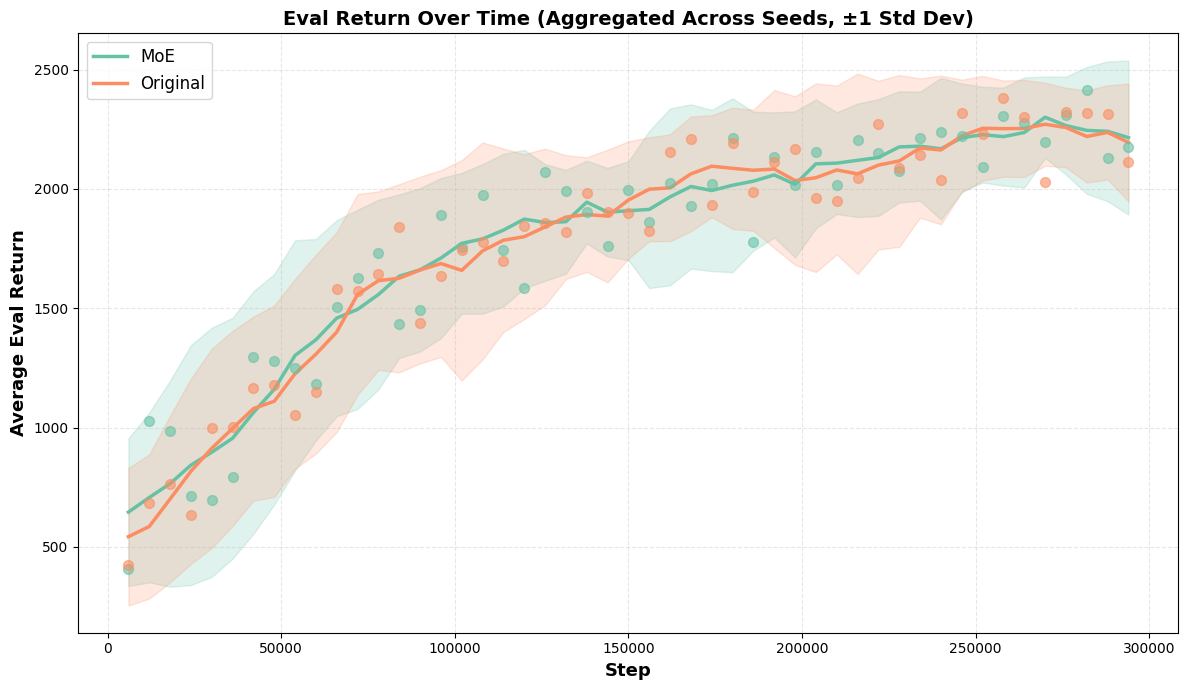

✓ Saved plot: results/individual_seeds_comparison_all_scores.png


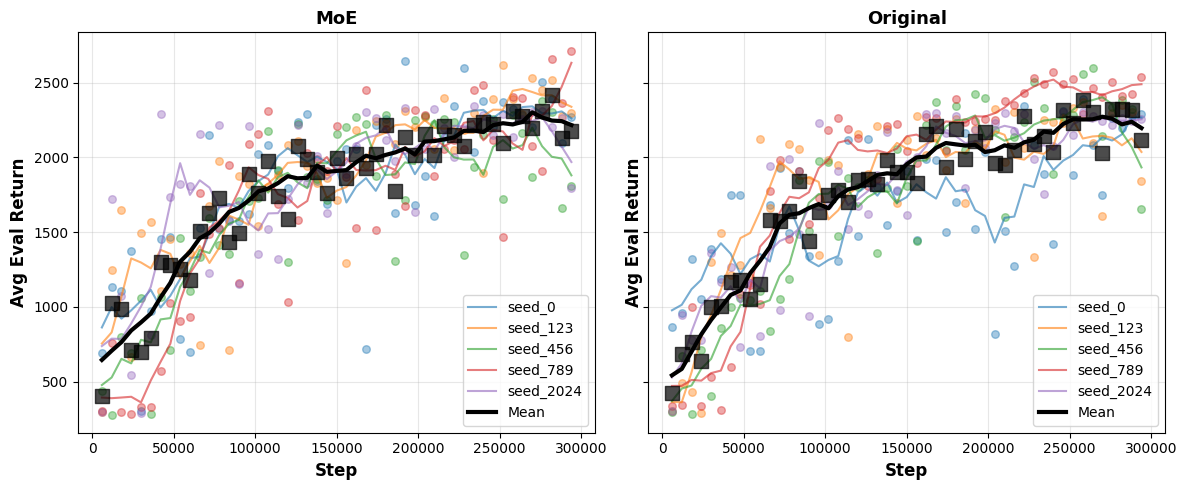


SUMMARY STATISTICS (Aggregated Across Seeds)

MoE:
  - Number of seeds: 5
  - Number of evaluation steps: 49
  - Final mean_eval_return: 2176.9571
  - Final std_eval_return: 385.7199
  - Max mean_eval_return: 2414.9463
  - Min mean_eval_return: 405.3212
  - Overall mean_eval_return: 1780.6202

Original:
  - Number of seeds: 5
  - Number of evaluation steps: 49
  - Final mean_eval_return: 2114.1949
  - Final std_eval_return: 358.8021
  - Max mean_eval_return: 2382.2549
  - Min mean_eval_return: 421.9521
  - Overall mean_eval_return: 1769.6291

✓ All processing complete!


In [2]:
# Define your experiment paths
experiment_paths = {
    'MoE': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/door_lock/moe_seed*",
    'Original': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/door_lock/logs_seed*",
}


# Run with all parameters
results = analyze_metrics(
    experiment_paths=experiment_paths,
    output_dir='results',
    smoothness=5,          # 3=minimal, 5=default, 7-9=more, 11+=heavy
    remove_lowest=False    # True to remove lowest score per step
)

# Remove lowest score - door lock

MULTI-SEED EVALUATION METRICS AGGREGATOR
Mode: REMOVE LOWEST SCORE
Smoothness: 5

📊 Processing experiment: MoE
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/door_lock/moe_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Processing seed 123... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Processing seed 456... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Processing seed 789... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Processing seed 2024... (removing lowest score)
    ✓ Processed 49 evaluation steps
   ✓ Successfully processed 5 seed(s)

📊 Processing experiment: Original
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/door_lock/logs_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Processing seed 123... (removing lowes

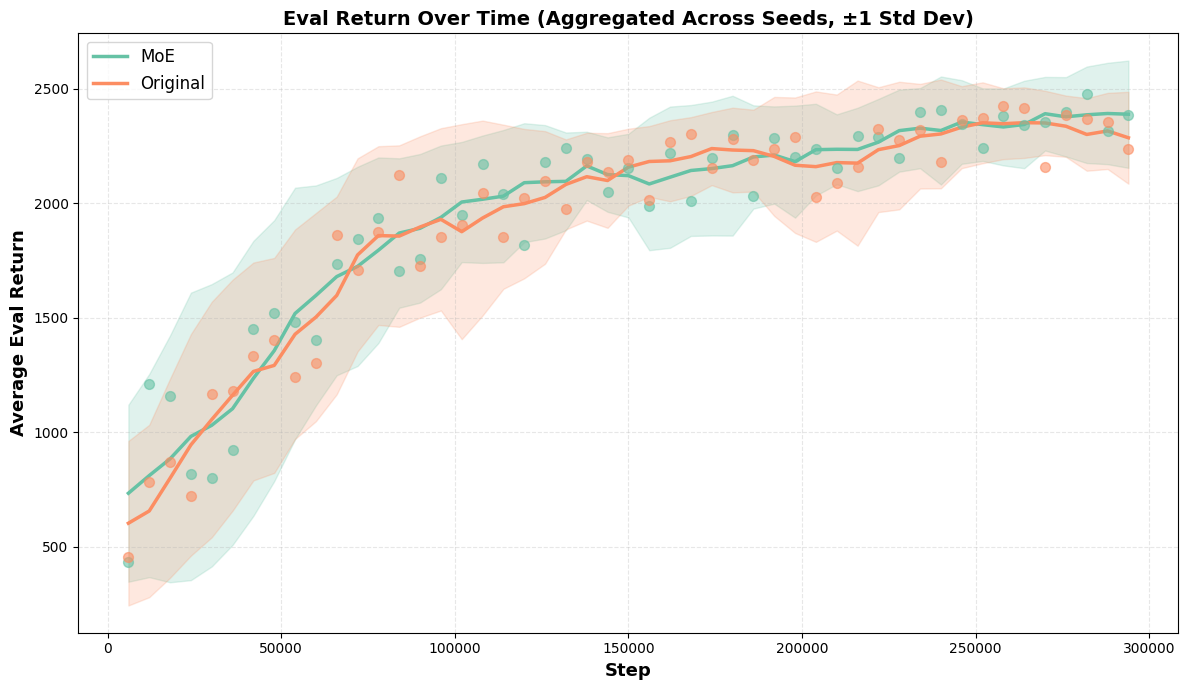

✓ Saved plot: results/individual_seeds_comparison_remove_lowest.png


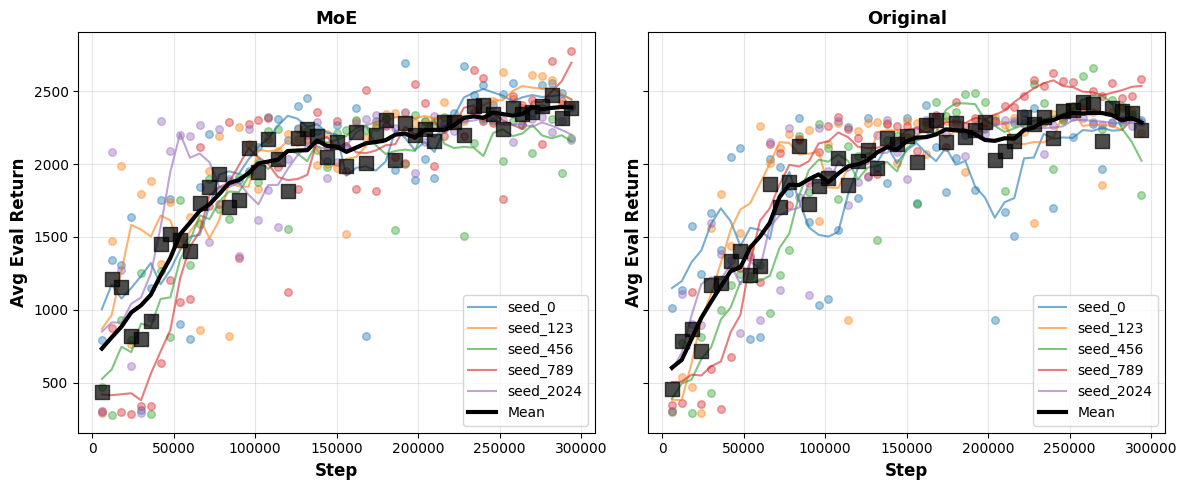


SUMMARY STATISTICS (Aggregated Across Seeds)

MoE:
  - Number of seeds: 5
  - Number of evaluation steps: 49
  - Final mean_eval_return: 2384.6191
  - Final std_eval_return: 248.9229
  - Max mean_eval_return: 2474.9366
  - Min mean_eval_return: 433.3760
  - Overall mean_eval_return: 1949.6172

Original:
  - Number of seeds: 5
  - Number of evaluation steps: 49
  - Final mean_eval_return: 2236.4136
  - Final std_eval_return: 286.3355
  - Max mean_eval_return: 2424.4799
  - Min mean_eval_return: 453.7024
  - Overall mean_eval_return: 1922.3979

✓ All processing complete!


In [3]:
# Define your experiment paths
experiment_paths = {
    'MoE': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/door_lock/moe_seed*",
    'Original': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/door_lock/logs_seed*",
}


# Run with all parameters
results = analyze_metrics(
    experiment_paths=experiment_paths,
    output_dir='results',
    smoothness=5,          # 3=minimal, 5=default, 7-9=more, 11+=heavy
    remove_lowest=True    # True to remove lowest score per step
)

# No removal - drawer-close

MULTI-SEED EVALUATION METRICS AGGREGATOR
Mode: KEEP ALL SCORES
Smoothness: 5

📊 Processing experiment: MoE
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner/moe_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0...
    ✓ Processed 49 evaluation steps
  Processing seed 123...
    ✓ Processed 49 evaluation steps
  Processing seed 456...
    ✓ Processed 49 evaluation steps
  Processing seed 789...
    ✓ Processed 49 evaluation steps
  Processing seed 2024...
    ✓ Processed 49 evaluation steps
   ✓ Successfully processed 5 seed(s)

📊 Processing experiment: Original
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner/logs_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0...
    ✓ Processed 49 evaluation steps
  Processing seed 123...
    ✓ Processed 49 evaluation steps
  Processing seed 456...
    ✓ Processed 49 evaluation steps
  Processing seed 789...
    ✓ P

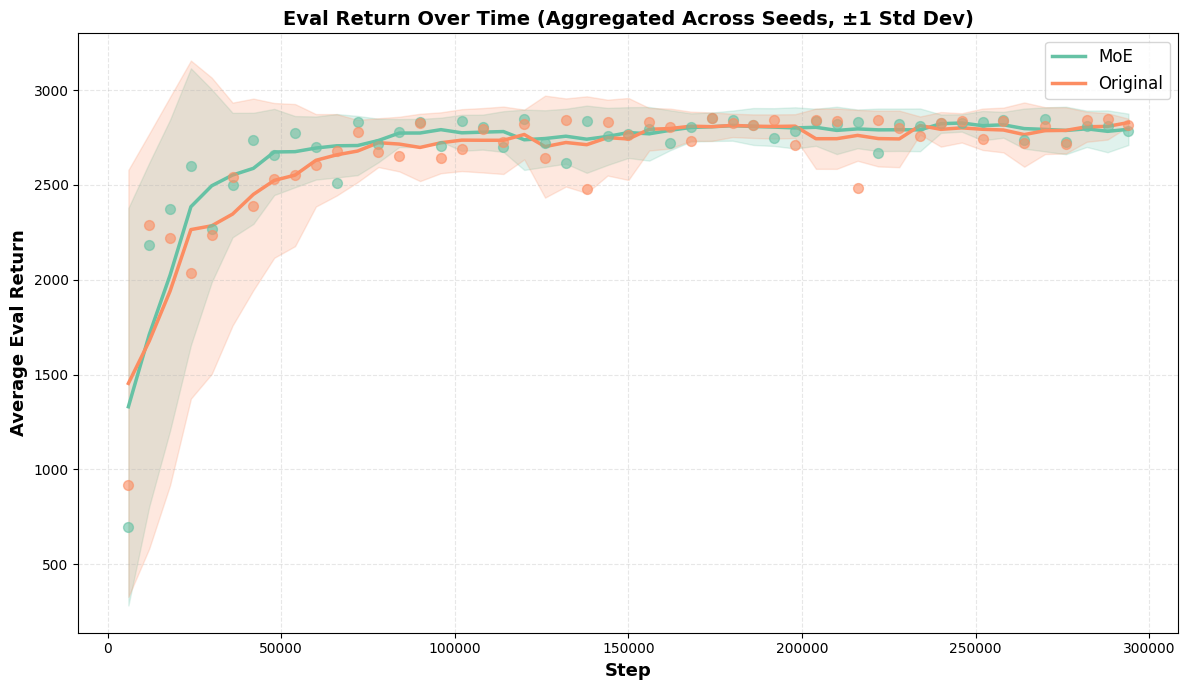

✓ Saved plot: results/individual_seeds_comparison_all_scores.png


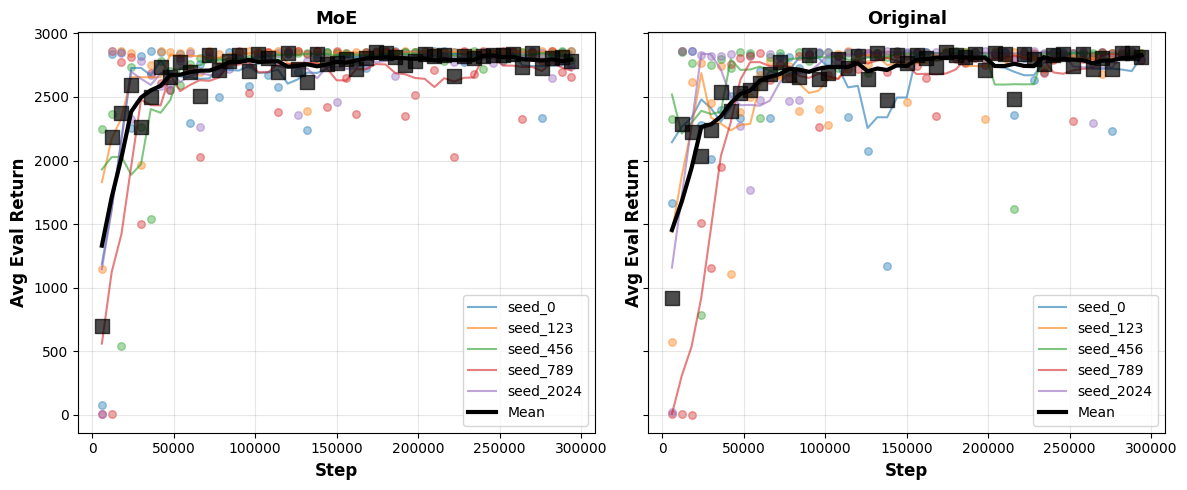


SUMMARY STATISTICS (Aggregated Across Seeds)

MoE:
  - Number of seeds: 5
  - Number of evaluation steps: 49
  - Final mean_eval_return: 2782.0310
  - Final std_eval_return: 84.8847
  - Max mean_eval_return: 2851.2390
  - Min mean_eval_return: 697.1058
  - Overall mean_eval_return: 2693.0332

Original:
  - Number of seeds: 5
  - Number of evaluation steps: 49
  - Final mean_eval_return: 2818.3905
  - Final std_eval_return: 26.6467
  - Max mean_eval_return: 2851.7085
  - Min mean_eval_return: 919.0925
  - Overall mean_eval_return: 2656.4902

✓ All processing complete!


In [4]:
# Define your experiment paths
experiment_paths = {
    'MoE': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner/moe_seed*",
    'Original': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner/logs_seed*",
}

# Run with all parameters
results = analyze_metrics(
    experiment_paths=experiment_paths,
    output_dir='results',
    smoothness=5,          # 3=minimal, 5=default, 7-9=more, 11+=heavy
    remove_lowest=False    # True to remove lowest score per step
)

# Remove lowest score - drawer_close

MULTI-SEED EVALUATION METRICS AGGREGATOR
Mode: REMOVE LOWEST SCORE
Smoothness: 5

📊 Processing experiment: MoE
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner/moe_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Processing seed 123... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Processing seed 456... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Processing seed 789... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Processing seed 2024... (removing lowest score)
    ✓ Processed 49 evaluation steps
   ✓ Successfully processed 5 seed(s)

📊 Processing experiment: Original
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner/logs_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Proc

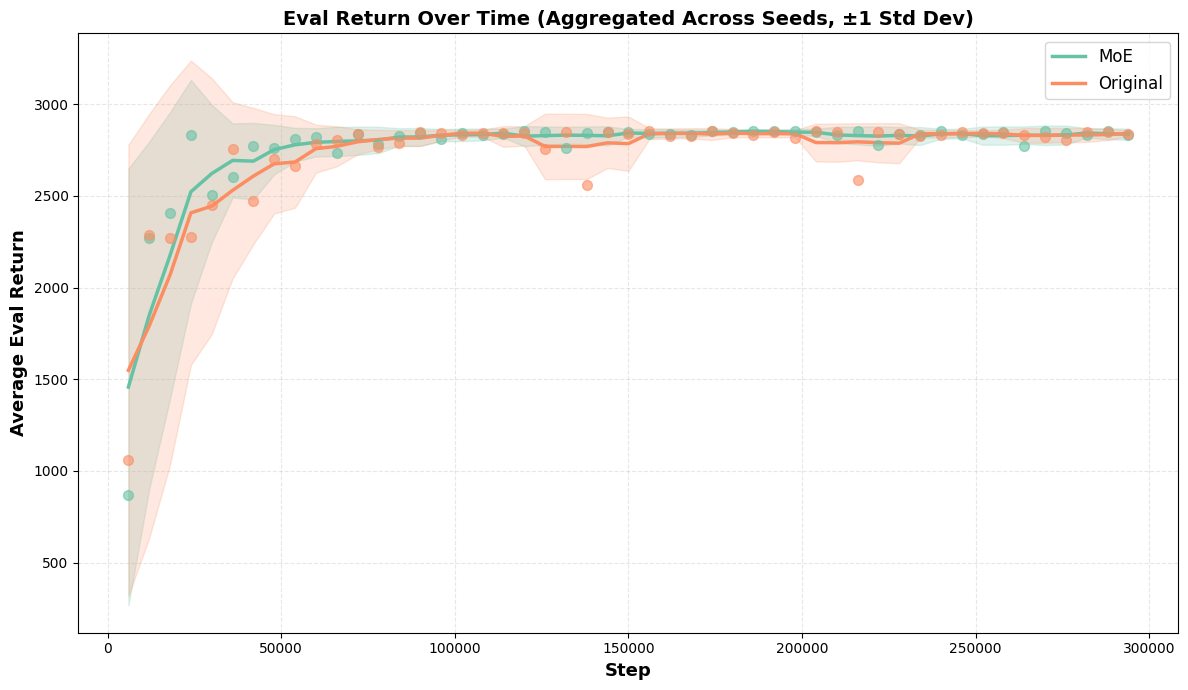

✓ Saved plot: results/individual_seeds_comparison_remove_lowest.png


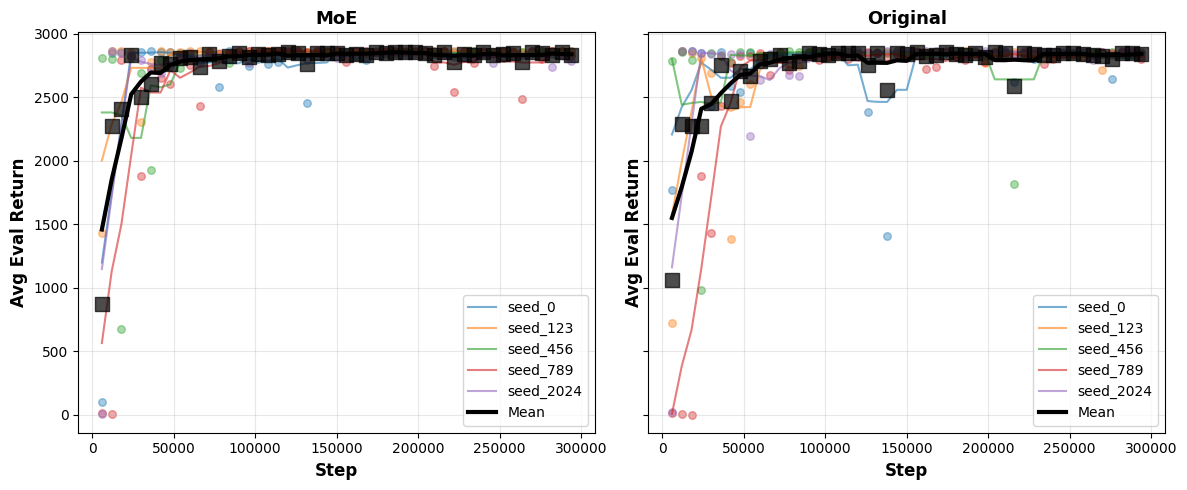


SUMMARY STATISTICS (Aggregated Across Seeds)

MoE:
  - Number of seeds: 5
  - Number of evaluation steps: 49
  - Final mean_eval_return: 2831.4117
  - Final std_eval_return: 30.7213
  - Max mean_eval_return: 2855.9129
  - Min mean_eval_return: 870.3993
  - Overall mean_eval_return: 2757.4679

Original:
  - Number of seeds: 5
  - Number of evaluation steps: 49
  - Final mean_eval_return: 2836.2943
  - Final std_eval_return: 21.2970
  - Max mean_eval_return: 2856.2660
  - Min mean_eval_return: 1061.0645
  - Overall mean_eval_return: 2728.6036

✓ All processing complete!


In [5]:
# Define your experiment paths
experiment_paths = {
    'MoE': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner/moe_seed*",
    'Original': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner/logs_seed*",
}

# Run with all parameters
results = analyze_metrics(
    experiment_paths=experiment_paths,
    output_dir='results',
    smoothness=5,          # 3=minimal, 5=default, 7-9=more, 11+=heavy
    remove_lowest=True    # True to remove lowest score per step
)

In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from pathlib import Path
import os
import re
from typing import Dict, Tuple, Optional

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def smooth_curve(x, y, window_size=5):
    """
    Smooth a curve using moving average (window averaging).
    
    window_size parameter (adjust for smoothness):
    - 3: Minimal smoothing (less averaging)
    - 5: Default (moderate smoothing)
    - 7-9: More smoothing
    - 11+: Heavy smoothing (very smooth)
    
    Larger window = smoother curve
    """
    if len(y) < window_size:
        return x, y
    
    try:
        # Apply moving average with centered window
        kernel = np.ones(window_size) / window_size
        # Pad the data for better edge handling
        y_padded = np.pad(y, (window_size//2, window_size//2), mode='edge')
        y_smooth = np.convolve(y_padded, kernel, mode='valid')
        
        return x, y_smooth
    except:
        return x, y

def find_seed_paths(base_pattern):
    """
    Find all seed directories matching the pattern.
    Returns a list of (seed_number, path) tuples sorted by seed.
    """
    base_dir = Path(base_pattern).parent
    pattern_name = Path(base_pattern).name
    
    # Convert glob pattern to regex
    regex_pattern = pattern_name.replace('*', '\\d+')
    regex = re.compile(f"^{regex_pattern}$")
    
    seed_paths = []
    
    if base_dir.exists():
        for item in base_dir.iterdir():
            if item.is_dir() and regex.match(item.name):
                # Extract seed number from directory name
                seed_match = re.search(r'(\d+)$', item.name)
                if seed_match:
                    seed_num = int(seed_match.group(1))
                    seed_paths.append((seed_num, item))
    
    # Sort by seed number
    seed_paths.sort(key=lambda x: x[0])
    return seed_paths

def find_metrics_file(seed_dir):
    """
    Find metrics.jsonl file in seed directory.
    Looks for metrics.jsonl in the directory or its subdirectories.
    """
    seed_path = Path(seed_dir)
    
    # Try direct metrics.jsonl
    direct_path = seed_path / 'metrics.jsonl'
    if direct_path.exists():
        return direct_path
    
    # Try searching in subdirectories
    for metrics_file in seed_path.rglob('metrics.jsonl'):
        return metrics_file
    
    return None

def aggregate_eval_metrics(jsonl_file, experiment_name, seed_num, remove_lowest=False):
    """
    Read JSONL file and aggregate eval scores into average and variance.
    
    Args:
        jsonl_file: Path to the metrics.jsonl file
        experiment_name: Name of the experiment
        seed_num: Seed number
        remove_lowest: If True, remove the lowest eval score from each step before aggregating
    
    Returns:
        DataFrame with aggregated metrics, or None if no valid data
    """
    print(f"  Processing seed {seed_num}..." + (" (removing lowest score)" if remove_lowest else ""))
    
    # Load all data
    data = []
    try:
        with open(jsonl_file, 'r') as f:
            for line in f:
                if line.strip():
                    data.append(json.loads(line))
    except FileNotFoundError:
        print(f"    ❌ File not found: {jsonl_file}")
        return None
    
    # Extract eval records (those with eval_return or mean_eval_success)
    eval_records = [d for d in data if 'eval_return' in d or 'mean_eval_success' in d]
    
    if not eval_records:
        print(f"    ❌ No eval records found")
        return None
    
    # Group eval records by step
    eval_by_step = defaultdict(list)
    for record in eval_records:
        step = record.get('step')
        if step is not None:
            eval_by_step[step].append(record)
    
    # Create aggregated dataset
    aggregated_data = []
    
    for step, eval_list in sorted(eval_by_step.items()):
        # Extract eval_return values (if present)
        eval_returns = [e['eval_return'] for e in eval_list if 'eval_return' in e]
        
        # Extract mean_eval_success values (if present)
        eval_successes = [e['mean_eval_success'] for e in eval_list if 'mean_eval_success' in e]
        
        # Process eval_return if available
        if eval_returns:
            # If remove_lowest is True and we have at least 2 evals, remove the lowest
            if remove_lowest and len(eval_returns) >= 2:
                min_idx = eval_returns.index(min(eval_returns))
                removed_lowest_score = min(eval_returns)
                eval_returns_filtered = [e for i, e in enumerate(eval_returns) if i != min_idx]
                num_evals_used = len(eval_returns_filtered)
            else:
                eval_returns_filtered = eval_returns
                removed_lowest_score = None
                num_evals_used = len(eval_returns)
            
            # Calculate mean and variance on (possibly filtered) scores
            avg_eval_return = np.mean(eval_returns_filtered)
            var_eval_return = np.var(eval_returns_filtered, ddof=1) if len(eval_returns_filtered) > 1 else 0
        else:
            avg_eval_return = None
            var_eval_return = None
            removed_lowest_score = None
            num_evals_used = 0
        
        # Process eval_success if available
        if eval_successes:
            avg_eval_success = np.mean(eval_successes)
        else:
            avg_eval_success = None
        
        aggregated_record = {
            'step': step,
            'seed': seed_num
        }
        
        # Add eval_return metrics if available
        if avg_eval_return is not None:
            aggregated_record['avg_eval_return'] = avg_eval_return
            aggregated_record['var_eval_return'] = var_eval_return
            aggregated_record['num_evals_used'] = num_evals_used
            if remove_lowest and removed_lowest_score is not None:
                aggregated_record['removed_lowest_score'] = removed_lowest_score
        
        # Add eval_success metric if available
        if avg_eval_success is not None:
            aggregated_record['mean_eval_success'] = avg_eval_success
        
        aggregated_data.append(aggregated_record)
    
    print(f"    ✓ Processed {len(aggregated_data)} evaluation steps")
    
    return pd.DataFrame(aggregated_data)

# ============================================================================
# MAIN ANALYSIS FUNCTION
# ============================================================================

def analyze_metrics(experiment_paths: Dict[str, str], 
                   output_dir: str = 'results',
                   smoothness: int = 5,
                   remove_lowest: bool = False) -> Dict[str, pd.DataFrame]:
    """
    Comprehensive metrics analysis pipeline.
    
    Args:
        experiment_paths: Dictionary mapping experiment names to path patterns
                         e.g., {'MoE': "/path/to/moe_seed*", 'Original': "/path/to/logs_seed*"}
        output_dir: Directory to save results (default: 'results')
        smoothness: Window size for moving average smoothing (default: 5)
                   - 3: Minimal smoothing
                   - 5: Default (moderate smoothing)
                   - 7-9: More smoothing
                   - 11+: Heavy smoothing
        remove_lowest: If True, remove lowest eval score per step (default: False)
    
    Returns:
        Dictionary of aggregated results {exp_name: aggregated_df}
    """
    
    print("="*70)
    print("MULTI-SEED EVALUATION METRICS AGGREGATOR")
    print("="*70)
    print(f"Mode: {'REMOVE LOWEST SCORE' if remove_lowest else 'KEEP ALL SCORES'}")
    print(f"Smoothness: {smoothness}")
    print("="*70)
    
    # Process all experiment categories and their seeds
    all_results = {}  # {exp_name: {seed: df, ...}, ...}
    
    for exp_name, base_pattern in experiment_paths.items():
        print(f"\n📊 Processing experiment: {exp_name}")
        print(f"   Pattern: {base_pattern}")
        
        seed_paths = find_seed_paths(base_pattern)
        
        if not seed_paths:
            print(f"   ⚠️  No seed directories found matching pattern!")
            continue
        
        print(f"   ✓ Found {len(seed_paths)} seed(s): {[s[0] for s in seed_paths]}")
        
        experiment_results = {}
        
        for seed_num, seed_dir in seed_paths:
            metrics_file = find_metrics_file(seed_dir)
            
            if metrics_file is None:
                print(f"  ❌ No metrics.jsonl found in {seed_dir}")
                continue
            
            df = aggregate_eval_metrics(metrics_file, exp_name, seed_num, remove_lowest=remove_lowest)
            
            if df is not None:
                experiment_results[seed_num] = df
        
        if experiment_results:
            all_results[exp_name] = experiment_results
            print(f"   ✓ Successfully processed {len(experiment_results)} seed(s)")
        else:
            print(f"   ❌ No valid seeds for {exp_name}")
    
    if not all_results:
        print("\n❌ No valid experiments to process!")
        return {}
    
    print(f"\n{'='*70}")
    print(f"✓ Successfully processed all experiments")
    print(f"{'='*70}\n")
    
    # ========================================================================
    # AGGREGATE ACROSS SEEDS FOR EACH EXPERIMENT
    # ========================================================================
    
    print("Aggregating metrics across seeds...\n")
    
    cross_seed_results = {}  # {exp_name: df_aggregated}
    
    for exp_name, seed_results in all_results.items():
        print(f"{exp_name}:")
        
        # Combine all seed data
        all_seed_dfs = list(seed_results.values())
        combined_df = pd.concat(all_seed_dfs, ignore_index=True)
        
        # Group by step and aggregate across seeds
        aggregated_by_step = []
        
        for step in sorted(combined_df['step'].unique()):
            step_data = combined_df[combined_df['step'] == step]
            
            aggregated_record = {
                'step': step,
                'num_seeds': len(step_data),
            }
            
            # Aggregate eval_return if available
            if 'avg_eval_return' in step_data.columns:
                eval_returns = step_data['avg_eval_return'].values
                aggregated_record['mean_eval_return'] = np.mean(eval_returns)
                aggregated_record['std_eval_return'] = np.std(eval_returns, ddof=1) if len(eval_returns) > 1 else 0
                aggregated_record['min_eval_return'] = np.min(eval_returns)
                aggregated_record['max_eval_return'] = np.max(eval_returns)
            
            # Aggregate mean_eval_success if available
            if 'mean_eval_success' in step_data.columns:
                eval_successes = step_data['mean_eval_success'].values
                aggregated_record['mean_eval_success'] = np.mean(eval_successes)
                aggregated_record['std_eval_success'] = np.std(eval_successes, ddof=1) if len(eval_successes) > 1 else 0
                aggregated_record['min_eval_success'] = np.min(eval_successes)
                aggregated_record['max_eval_success'] = np.max(eval_successes)
            
            aggregated_by_step.append(aggregated_record)
        
        df_agg = pd.DataFrame(aggregated_by_step)
        cross_seed_results[exp_name] = df_agg
        
        print(f"  - Seeds processed: {len(seed_results)}")
        print(f"  - Evaluation steps: {len(df_agg)}")
        if 'mean_eval_return' in df_agg.columns:
            print(f"  - Final mean_eval_return: {df_agg['mean_eval_return'].iloc[-1]:.2f} ± {df_agg['std_eval_return'].iloc[-1]:.2f}")
        if 'mean_eval_success' in df_agg.columns:
            print(f"  - Final mean_eval_success: {df_agg['mean_eval_success'].iloc[-1]:.4f} ± {df_agg['std_eval_success'].iloc[-1]:.4f}")
        print()
    
    # ========================================================================
    # SAVE AGGREGATED RESULTS
    # ========================================================================
    
    results_path = Path(output_dir)
    results_path.mkdir(parents=True, exist_ok=True)
    
    # Add mode suffix to output files
    mode_suffix = "_remove_lowest" if remove_lowest else "_all_scores"
    
    print("Saving aggregated results...\n")
    
    for exp_name, df_agg in cross_seed_results.items():
        # Save CSV
        csv_path = results_path / f'{exp_name}_cross_seed_aggregated{mode_suffix}.csv'
        df_agg.to_csv(csv_path, index=False)
        print(f"  ✓ {exp_name} CSV: {csv_path}")
        
        # Save JSONL
        jsonl_path = results_path / f'{exp_name}_cross_seed_aggregated{mode_suffix}.jsonl'
        with open(jsonl_path, 'w') as f:
            for _, record in df_agg.iterrows():
                f.write(json.dumps(record.to_dict()) + '\n')
        print(f"  ✓ {exp_name} JSONL: {jsonl_path}")
    
    # Also save individual seed results for reference
    print()
    for exp_name, seed_results in all_results.items():
        exp_dir = results_path / (exp_name + mode_suffix)
        exp_dir.mkdir(parents=True, exist_ok=True)
        
        for seed_num, df in seed_results.items():
            seed_csv_path = exp_dir / f'seed_{seed_num}_metrics.csv'
            df.to_csv(seed_csv_path, index=False)
        
        print(f"  ✓ {exp_name} individual seed results saved to {exp_dir}/")
    
    # ========================================================================
    # PLOTTING - COMPARISON ACROSS EXPERIMENTS
    # ========================================================================
    
    print("\n" + "="*70)
    print("GENERATING PLOTS")
    print("="*70 + "\n")
    
    # Plot 1: Eval return with error bands (mean ± std across seeds)
    if any('mean_eval_return' in df.columns for df in cross_seed_results.values()):
        fig, ax = plt.subplots(figsize=(12, 7))
        
        colors = plt.cm.Set2(range(len(cross_seed_results)))
        
        for (exp_name, df_agg), color in zip(cross_seed_results.items(), colors):
            if 'mean_eval_return' in df_agg.columns:
                # Convert to numpy arrays for plotting
                step = df_agg['step'].values
                mean_return = df_agg['mean_eval_return'].values
                std_return = df_agg['std_eval_return'].values
                
                # Apply moving average smoothing to both mean and std
                step_smooth, mean_smooth = smooth_curve(step, mean_return, window_size=smoothness)
                _, std_smooth = smooth_curve(step, std_return, window_size=smoothness)
                
                # Plot mean line (smooth)
                ax.plot(step_smooth, mean_smooth, 
                        label=exp_name, color=color, linewidth=2.5)
                
                # Plot original points as markers
                ax.scatter(step, mean_return, color=color, s=50, zorder=5, alpha=0.6)
                
                # Add shaded error region (±1 std) - use smoothed std
                ax.fill_between(step_smooth, 
                                 mean_smooth - std_smooth,
                                 mean_smooth + std_smooth,
                                 color=color, alpha=0.2)
        
        ax.set_xlabel('Step', fontsize=13, fontweight='bold')
        ax.set_ylabel('Average Eval Return', fontsize=13, fontweight='bold')
        ax.set_title('Eval Return Over Time (Aggregated Across Seeds, ±1 Std Dev)', 
                     fontsize=14, fontweight='bold')
        ax.legend(fontsize=12, loc='best')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plot_path_1 = results_path / f'cross_seed_eval_return_comparison{mode_suffix}.png'
        plt.savefig(plot_path_1, dpi=300, bbox_inches='tight')
        print(f"✓ Saved plot: {plot_path_1}")
        plt.show()
        plt.close()
    
    # Plot 2: Individual seed runs (separate subplots or overlaid)
    fig, axes = plt.subplots(1, len(all_results), figsize=(6*len(all_results), 5), sharey=True)
    
    if len(all_results) == 1:
        axes = [axes]
    
    for (exp_name, seed_results), ax in zip(all_results.items(), axes):
        
        # Plot each seed (smooth with moving average)
        for seed_num, df in seed_results.items():
            if 'avg_eval_return' in df.columns:
                step = df['step'].values
                avg_return = df['avg_eval_return'].values
                
                # Apply moving average smoothing
                step_smooth, avg_smooth = smooth_curve(step, avg_return, window_size=smoothness)
                ax.plot(step_smooth, avg_smooth, 
                        label=f'seed_{seed_num}', alpha=0.6, linewidth=1.5)
                ax.scatter(step, avg_return, alpha=0.4, s=30)
        
        # Plot mean across seeds (smooth and bold)
        if 'mean_eval_return' in cross_seed_results[exp_name].columns:
            df_mean = cross_seed_results[exp_name]
            step_mean = df_mean['step'].values
            mean_return = df_mean['mean_eval_return'].values
            step_mean_smooth, mean_smooth = smooth_curve(step_mean, mean_return, window_size=smoothness)
            ax.plot(step_mean_smooth, mean_smooth, 
                    label='Mean', color='black', linewidth=3)
            ax.scatter(step_mean, mean_return, color='black', s=100, marker='s', zorder=10, alpha=0.7)
        
        ax.set_xlabel('Step', fontsize=12, fontweight='bold')
        ax.set_ylabel('Avg Eval Return', fontsize=12, fontweight='bold')
        ax.set_title(exp_name, fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_path_2 = results_path / f'individual_seeds_comparison{mode_suffix}.png'
    plt.savefig(plot_path_2, dpi=300, bbox_inches='tight')
    print(f"✓ Saved plot: {plot_path_2}")
    plt.show()
    plt.close()
    
    # Plot 3: Mean eval success across experiments (with error bands)
    if any('mean_eval_success' in df.columns for df in cross_seed_results.values()):
        fig, ax = plt.subplots(figsize=(12, 7))
        
        colors = plt.cm.Set2(range(len(cross_seed_results)))
        
        for (exp_name, df_agg), color in zip(cross_seed_results.items(), colors):
            if 'mean_eval_success' in df_agg.columns:
                step = df_agg['step'].values
                mean_success = df_agg['mean_eval_success'].values
                std_success = df_agg['std_eval_success'].values
                
                # Apply moving average smoothing
                step_smooth, success_smooth = smooth_curve(step, mean_success, window_size=smoothness)
                _, std_smooth = smooth_curve(step, std_success, window_size=smoothness)
                
                # Plot mean line (smooth)
                ax.plot(step_smooth, success_smooth, 
                        label=exp_name, color=color, linewidth=2.5)
                
                # Plot original points as markers
                ax.scatter(step, mean_success, color=color, s=50, zorder=5, alpha=0.6)
                
                # Add shaded error region (±1 std)
                ax.fill_between(step_smooth, 
                                 success_smooth - std_smooth,
                                 success_smooth + std_smooth,
                                 color=color, alpha=0.2)
        
        ax.set_xlabel('Step', fontsize=13, fontweight='bold')
        ax.set_ylabel('Mean Eval Success', fontsize=13, fontweight='bold')
        ax.set_title('Eval Success Over Time (Aggregated Across Seeds, ±1 Std Dev)', 
                     fontsize=14, fontweight='bold')
        ax.legend(fontsize=12, loc='best')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_ylim([0, 1.05])  # Success is typically 0-1
        
        plt.tight_layout()
        plot_path_3 = results_path / f'cross_seed_eval_success_comparison{mode_suffix}.png'
        plt.savefig(plot_path_3, dpi=300, bbox_inches='tight')
        print(f"✓ Saved plot: {plot_path_3}")
        plt.show()
        plt.close()
    
    # Plot 4: Individual seed runs for success (if available)
    if any('mean_eval_success' in seed_results[seed_num].columns 
           for seed_results in all_results.values() 
           for seed_num in seed_results.keys()):
        fig, axes = plt.subplots(1, len(all_results), figsize=(6*len(all_results), 5), sharey=True)
        
        if len(all_results) == 1:
            axes = [axes]
        
        for (exp_name, seed_results), ax in zip(all_results.items(), axes):
            
            # Plot each seed (smooth with moving average)
            for seed_num, df in seed_results.items():
                if 'mean_eval_success' in df.columns:
                    step = df['step'].values
                    success = df['mean_eval_success'].values
                    
                    # Apply moving average smoothing
                    step_smooth, success_smooth = smooth_curve(step, success, window_size=smoothness)
                    ax.plot(step_smooth, success_smooth, 
                            label=f'seed_{seed_num}', alpha=0.6, linewidth=1.5)
                    ax.scatter(step, success, alpha=0.4, s=30)
            
            # Plot mean across seeds (smooth and bold)
            if 'mean_eval_success' in cross_seed_results[exp_name].columns:
                df_mean = cross_seed_results[exp_name]
                step_mean = df_mean['step'].values
                mean_success = df_mean['mean_eval_success'].values
                step_mean_smooth, success_smooth = smooth_curve(step_mean, mean_success, window_size=smoothness)
                ax.plot(step_mean_smooth, success_smooth, 
                        label='Mean', color='black', linewidth=3)
                ax.scatter(step_mean, mean_success, color='black', s=100, marker='s', zorder=10, alpha=0.7)
            
            ax.set_xlabel('Step', fontsize=12, fontweight='bold')
            ax.set_ylabel('Mean Eval Success', fontsize=12, fontweight='bold')
            ax.set_title(f'{exp_name} - Success Rates', fontsize=13, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.set_ylim([0, 1.05])
        
        plt.tight_layout()
        plot_path_4 = results_path / f'individual_seeds_success_comparison{mode_suffix}.png'
        plt.savefig(plot_path_4, dpi=300, bbox_inches='tight')
        print(f"✓ Saved plot: {plot_path_4}")
        plt.show()
        plt.close()
    
    # Plot 5: Variance trend for eval return (std dev across seeds over time)
    if any('std_eval_return' in df.columns for df in cross_seed_results.values()):
        fig, ax = plt.subplots(figsize=(12, 7))
        
        colors = plt.cm.Set2(range(len(cross_seed_results)))
        
        for (exp_name, df_agg), color in zip(cross_seed_results.items(), colors):
            if 'std_eval_return' in df_agg.columns:
                step = df_agg['step'].values
                std_return = df_agg['std_eval_return'].values
                
                # Apply moving average smoothing to std
                step_smooth, std_smooth = smooth_curve(step, std_return, window_size=smoothness)
                
                # Plot std line (smooth)
                ax.plot(step_smooth, std_smooth, 
                        label=exp_name, color=color, linewidth=2.5, marker='o', markersize=6)
                
                # Plot original points
                ax.scatter(step, std_return, color=color, s=50, zorder=5, alpha=0.6)
        
        ax.set_xlabel('Step', fontsize=13, fontweight='bold')
        ax.set_ylabel('Std Dev of Eval Return (Across Seeds)', fontsize=13, fontweight='bold')
        ax.set_title('Eval Return Variance Trend Over Time (±1 Std Dev Across Seeds)', 
                     fontsize=14, fontweight='bold')
        ax.legend(fontsize=12, loc='best')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plot_path_variance_return = results_path / f'variance_trend_eval_return{mode_suffix}.png'
        plt.savefig(plot_path_variance_return, dpi=300, bbox_inches='tight')
        print(f"✓ Saved plot: {plot_path_variance_return}")
        plt.show()
        plt.close()
    
    # Plot 6: Variance trend for success rate (std dev across seeds over time)
    if any('std_eval_success' in df.columns for df in cross_seed_results.values()):
        fig, ax = plt.subplots(figsize=(12, 7))
        
        colors = plt.cm.Set2(range(len(cross_seed_results)))
        
        for (exp_name, df_agg), color in zip(cross_seed_results.items(), colors):
            if 'std_eval_success' in df_agg.columns:
                step = df_agg['step'].values
                std_success = df_agg['std_eval_success'].values
                
                # Apply moving average smoothing to std
                step_smooth, std_smooth = smooth_curve(step, std_success, window_size=smoothness)
                
                # Plot std line (smooth)
                ax.plot(step_smooth, std_smooth, 
                        label=exp_name, color=color, linewidth=2.5, marker='s', markersize=6)
                
                # Plot original points
                ax.scatter(step, std_success, color=color, s=50, zorder=5, alpha=0.6)
        
        ax.set_xlabel('Step', fontsize=13, fontweight='bold')
        ax.set_ylabel('Std Dev of Eval Success (Across Seeds)', fontsize=13, fontweight='bold')
        ax.set_title('Eval Success Variance Trend Over Time (±1 Std Dev Across Seeds)', 
                     fontsize=14, fontweight='bold')
        ax.legend(fontsize=12, loc='best')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plot_path_variance_success = results_path / f'variance_trend_eval_success{mode_suffix}.png'
        plt.savefig(plot_path_variance_success, dpi=300, bbox_inches='tight')
        print(f"✓ Saved plot: {plot_path_variance_success}")
        plt.show()
        plt.close()
    
    # Plot 7: Combined variance comparison (eval return vs success rate)
    if (any('std_eval_return' in df.columns for df in cross_seed_results.values()) and
        any('std_eval_success' in df.columns for df in cross_seed_results.values())):
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        colors = plt.cm.Set2(range(len(cross_seed_results)))
        
        # Left plot: Eval Return Variance
        ax = axes[0]
        for (exp_name, df_agg), color in zip(cross_seed_results.items(), colors):
            if 'std_eval_return' in df_agg.columns:
                step = df_agg['step'].values
                std_return = df_agg['std_eval_return'].values
                step_smooth, std_smooth = smooth_curve(step, std_return, window_size=smoothness)
                ax.plot(step_smooth, std_smooth, label=exp_name, color=color, linewidth=2.5, marker='o')
                ax.scatter(step, std_return, color=color, s=50, zorder=5, alpha=0.6)
        
        ax.set_xlabel('Step', fontsize=12, fontweight='bold')
        ax.set_ylabel('Std Dev', fontsize=12, fontweight='bold')
        ax.set_title('Eval Return Variance', fontsize=13, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        # Right plot: Success Rate Variance
        ax = axes[1]
        for (exp_name, df_agg), color in zip(cross_seed_results.items(), colors):
            if 'std_eval_success' in df_agg.columns:
                step = df_agg['step'].values
                std_success = df_agg['std_eval_success'].values
                step_smooth, std_smooth = smooth_curve(step, std_success, window_size=smoothness)
                ax.plot(step_smooth, std_smooth, label=exp_name, color=color, linewidth=2.5, marker='s')
                ax.scatter(step, std_success, color=color, s=50, zorder=5, alpha=0.6)
        
        ax.set_xlabel('Step', fontsize=12, fontweight='bold')
        ax.set_ylabel('Std Dev', fontsize=12, fontweight='bold')
        ax.set_title('Eval Success Variance', fontsize=13, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plot_path_variance_combined = results_path / f'variance_trend_combined{mode_suffix}.png'
        plt.savefig(plot_path_variance_combined, dpi=300, bbox_inches='tight')
        print(f"✓ Saved plot: {plot_path_variance_combined}")
        plt.show()
        plt.close()
    
    # ========================================================================
    # SUMMARY STATISTICS
    # ========================================================================
    
    print("\n" + "="*70)
    print("SUMMARY STATISTICS (Aggregated Across Seeds)")
    print("="*70)
    
    for exp_name, df_agg in cross_seed_results.items():
        print(f"\n{exp_name}:")
        print(f"  - Number of seeds: {df_agg['num_seeds'].iloc[0]}")
        print(f"  - Number of evaluation steps: {len(df_agg)}")
        if 'mean_eval_return' in df_agg.columns:
            print(f"  - Final mean_eval_return: {df_agg['mean_eval_return'].iloc[-1]:.4f}")
            print(f"  - Final std_eval_return: {df_agg['std_eval_return'].iloc[-1]:.4f}")
            print(f"  - Max mean_eval_return: {df_agg['mean_eval_return'].max():.4f}")
            print(f"  - Min mean_eval_return: {df_agg['mean_eval_return'].min():.4f}")
            print(f"  - Overall mean_eval_return: {df_agg['mean_eval_return'].mean():.4f}")
        if 'mean_eval_success' in df_agg.columns:
            print(f"  - Final mean_eval_success: {df_agg['mean_eval_success'].iloc[-1]:.4f}")
            print(f"  - Final std_eval_success: {df_agg['std_eval_success'].iloc[-1]:.4f}")
            print(f"  - Max mean_eval_success: {df_agg['mean_eval_success'].max():.4f}")
            print(f"  - Min mean_eval_success: {df_agg['mean_eval_success'].min():.4f}")
            print(f"  - Overall mean_eval_success: {df_agg['mean_eval_success'].mean():.4f}")
    
    print("\n" + "="*70)
    print("✓ All processing complete!")
    print("="*70)
    
    return cross_seed_results

# No removal - drawer close (corner2)

MULTI-SEED EVALUATION METRICS AGGREGATOR
Mode: KEEP ALL SCORES
Smoothness: 3

📊 Processing experiment: MoE
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner2/moe_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0...
    ✓ Processed 49 evaluation steps
  Processing seed 123...
    ✓ Processed 49 evaluation steps
  Processing seed 456...
    ✓ Processed 49 evaluation steps
  Processing seed 789...
    ✓ Processed 49 evaluation steps
  Processing seed 2024...
    ✓ Processed 49 evaluation steps
   ✓ Successfully processed 5 seed(s)

📊 Processing experiment: Original
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner2/original_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0...
    ✓ Processed 49 evaluation steps
  Processing seed 123...
    ✓ Processed 49 evaluation steps
  Processing seed 456...
    ✓ Processed 49 evaluation steps
  Processing seed 789...
 

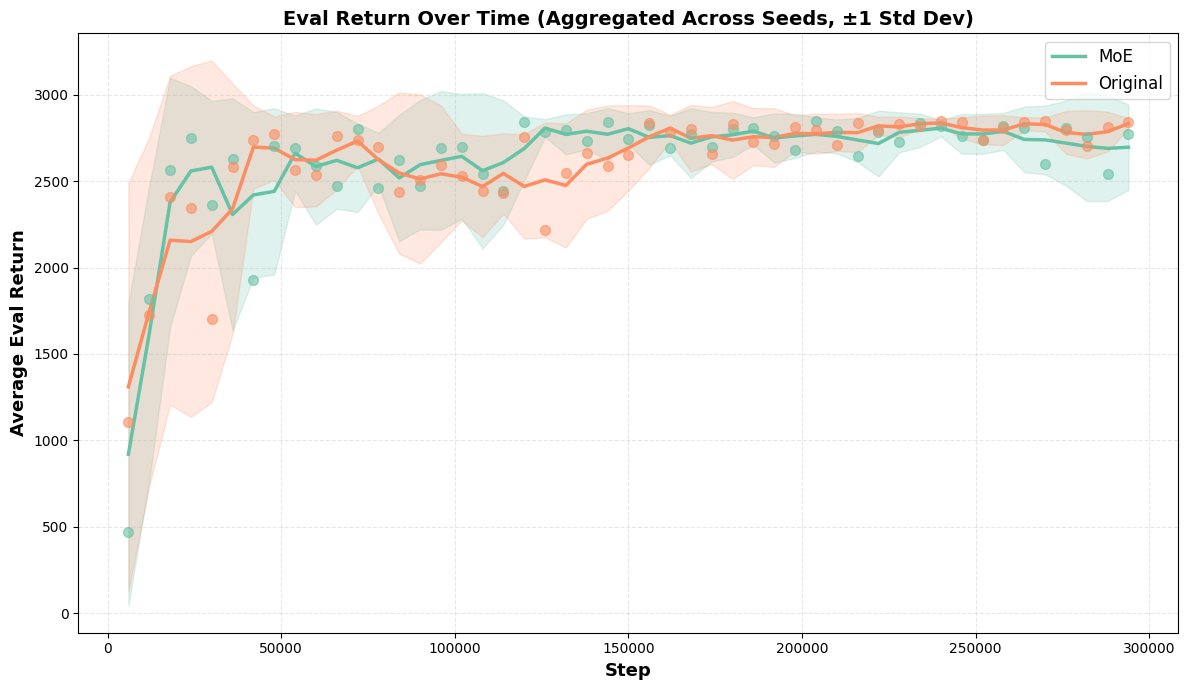

✓ Saved plot: results/individual_seeds_comparison_all_scores.png


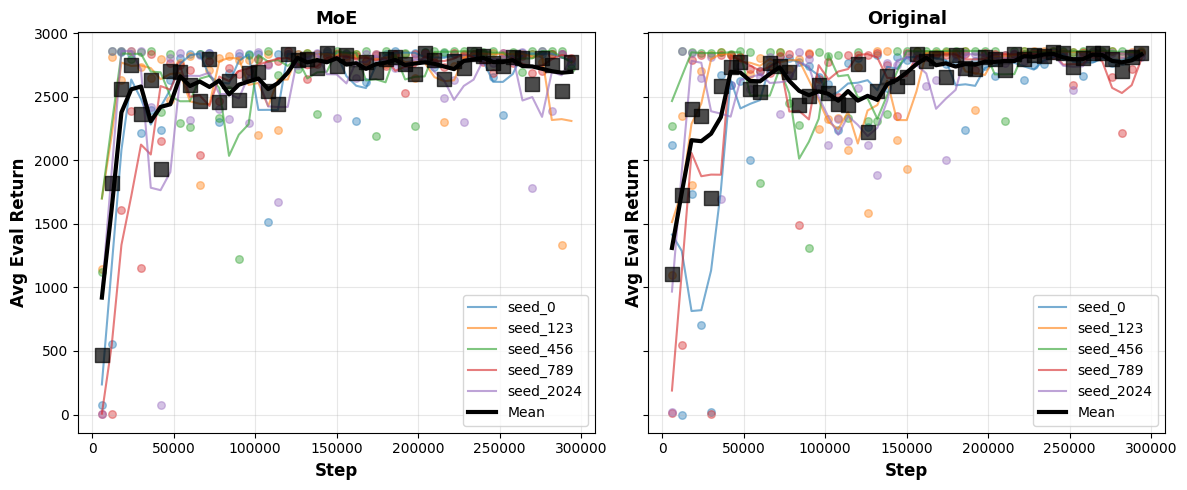

✓ Saved plot: results/cross_seed_eval_success_comparison_all_scores.png


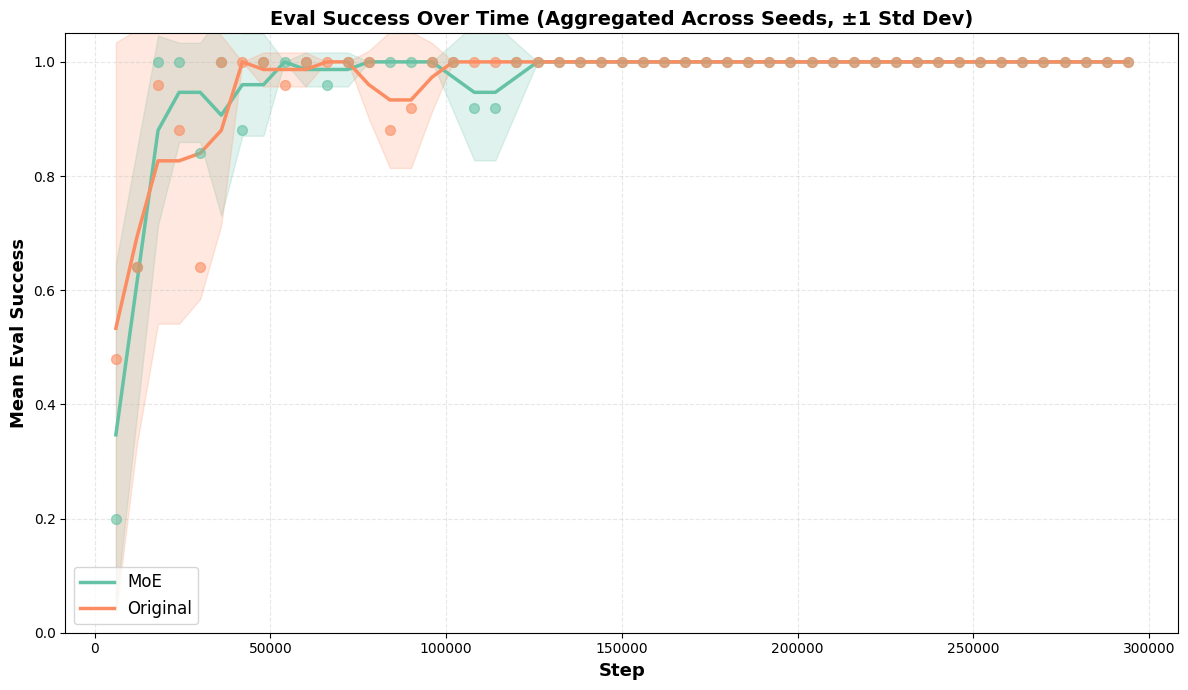

✓ Saved plot: results/individual_seeds_success_comparison_all_scores.png


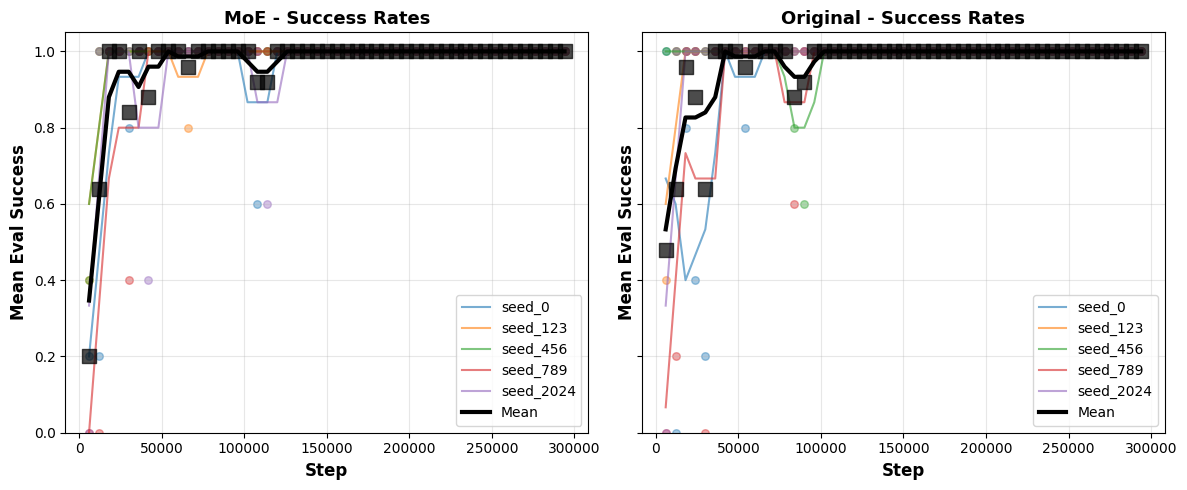

✓ Saved plot: results/variance_trend_eval_return_all_scores.png


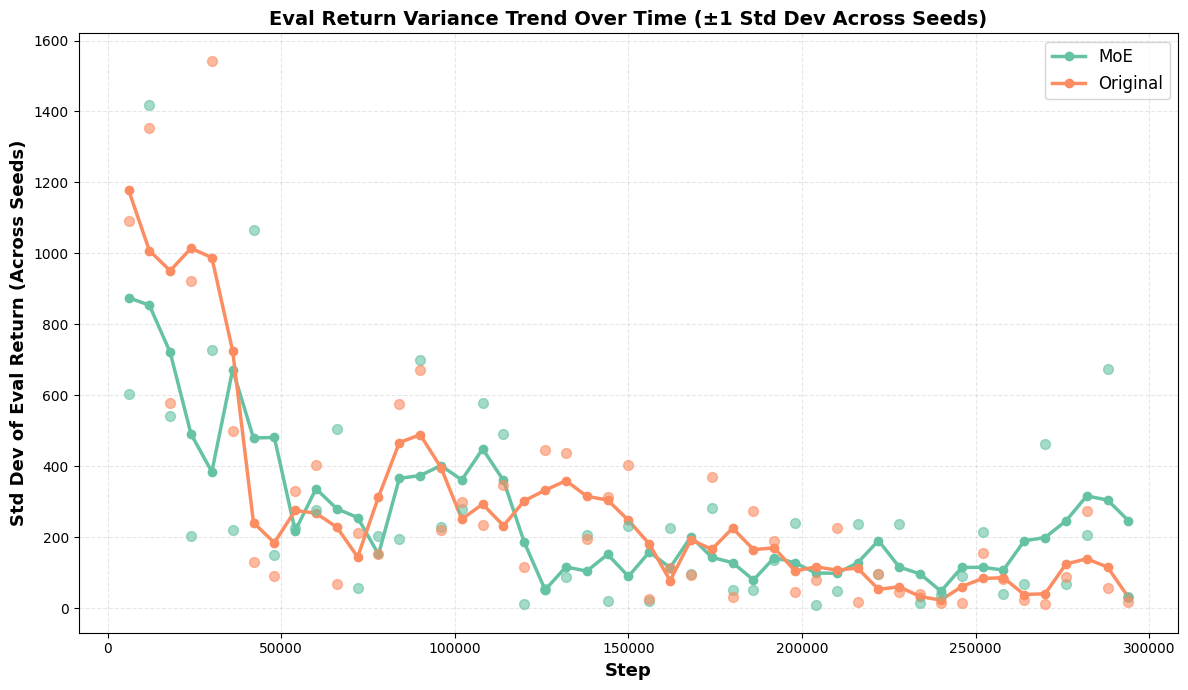

✓ Saved plot: results/variance_trend_eval_success_all_scores.png


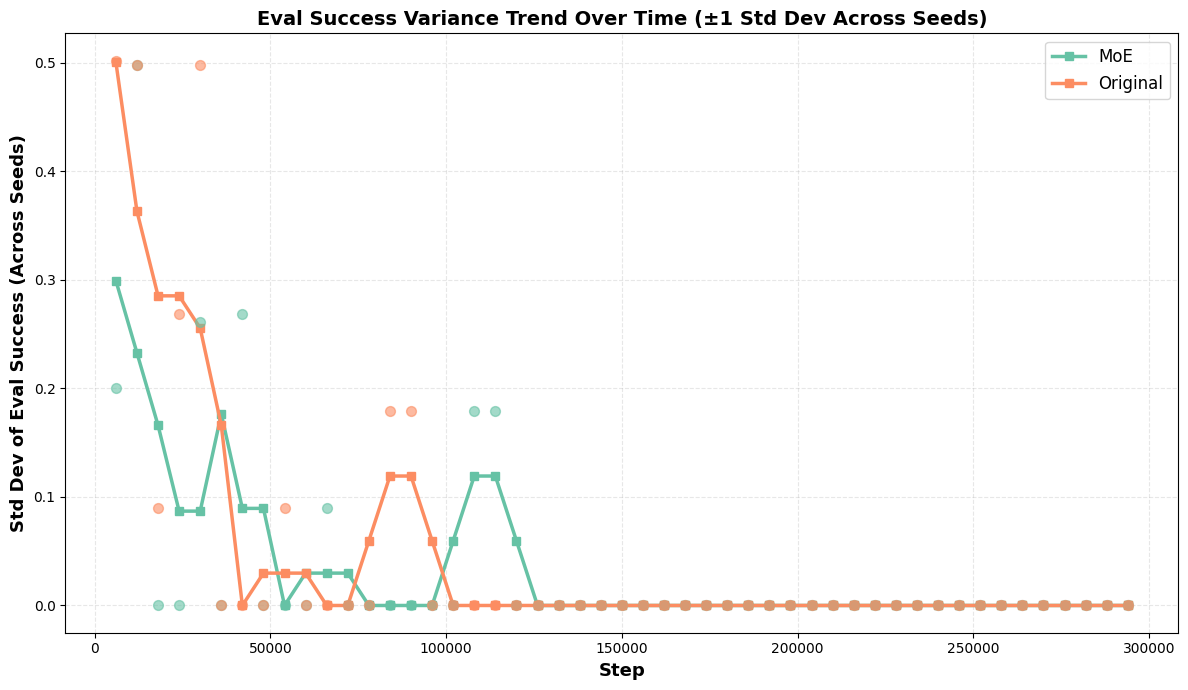

✓ Saved plot: results/variance_trend_combined_all_scores.png


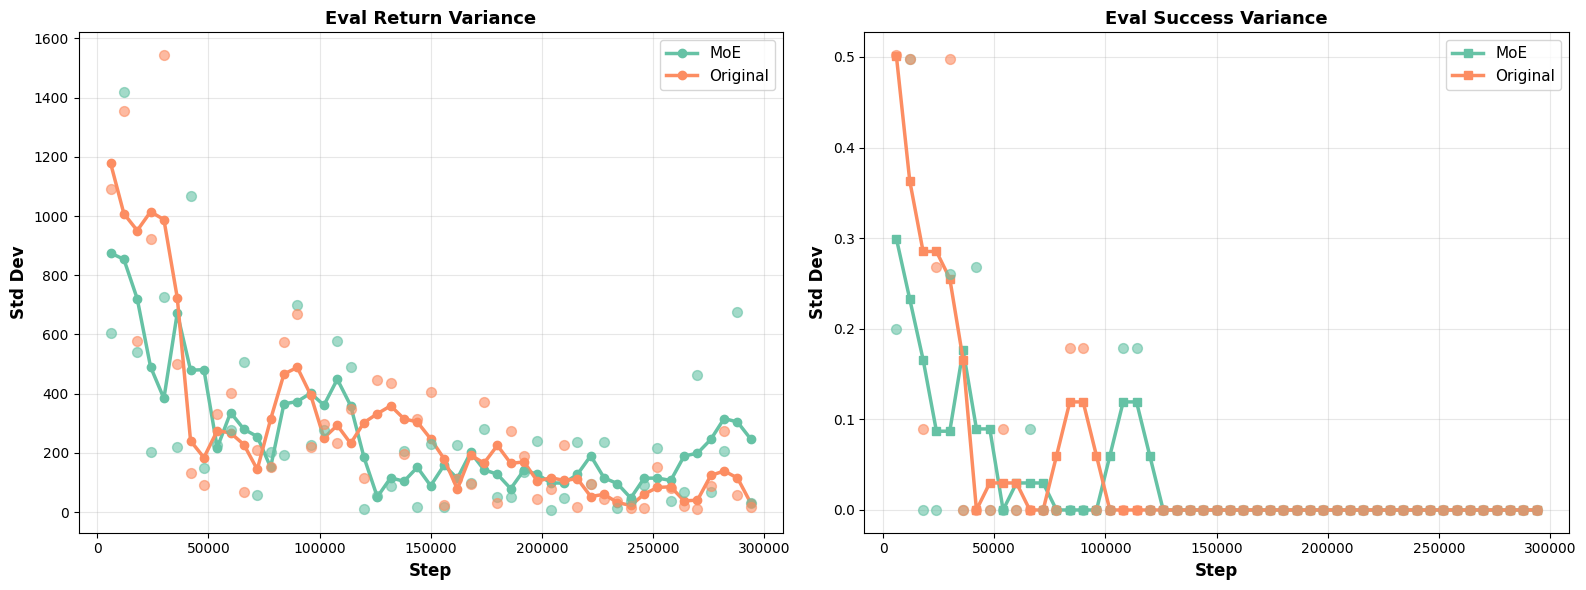


SUMMARY STATISTICS (Aggregated Across Seeds)

MoE:
  - Number of seeds: 5
  - Number of evaluation steps: 49
  - Final mean_eval_return: 2772.9084
  - Final std_eval_return: 32.4325
  - Max mean_eval_return: 2845.0686
  - Min mean_eval_return: 470.8611
  - Overall mean_eval_return: 2622.4987
  - Final mean_eval_success: 1.0000
  - Final std_eval_success: 0.0000
  - Max mean_eval_success: 1.0000
  - Min mean_eval_success: 0.2000
  - Overall mean_eval_success: 0.9665

Original:
  - Number of seeds: 5
  - Number of evaluation steps: 49
  - Final mean_eval_return: 2842.6797
  - Final std_eval_return: 17.0575
  - Max mean_eval_return: 2847.9131
  - Min mean_eval_return: 1103.6589
  - Overall mean_eval_return: 2613.2434
  - Final mean_eval_success: 1.0000
  - Final std_eval_success: 0.0000
  - Max mean_eval_success: 1.0000
  - Min mean_eval_success: 0.4800
  - Overall mean_eval_success: 0.9665

✓ All processing complete!


In [7]:
# Define your experiment paths
experiment_paths = {
    'MoE': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner2/moe_seed*",
    'Original': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner2/original_seed*",
}

# Run with all parameters
results = analyze_metrics(
    experiment_paths=experiment_paths,
    output_dir='results',
    smoothness=3,          # 3=minimal, 5=default, 7-9=more, 11+=heavy
    remove_lowest=False    # True to remove lowest score per step
)

# Removal - drawer close (corner2)

MULTI-SEED EVALUATION METRICS AGGREGATOR
Mode: REMOVE LOWEST SCORE
Smoothness: 3

📊 Processing experiment: MoE
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner2/moe_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Processing seed 123... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Processing seed 456... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Processing seed 789... (removing lowest score)
    ✓ Processed 49 evaluation steps
  Processing seed 2024... (removing lowest score)
    ✓ Processed 49 evaluation steps
   ✓ Successfully processed 5 seed(s)

📊 Processing experiment: Original
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner2/original_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0... (removing lowest score)
    ✓ Processed 49 evaluation steps


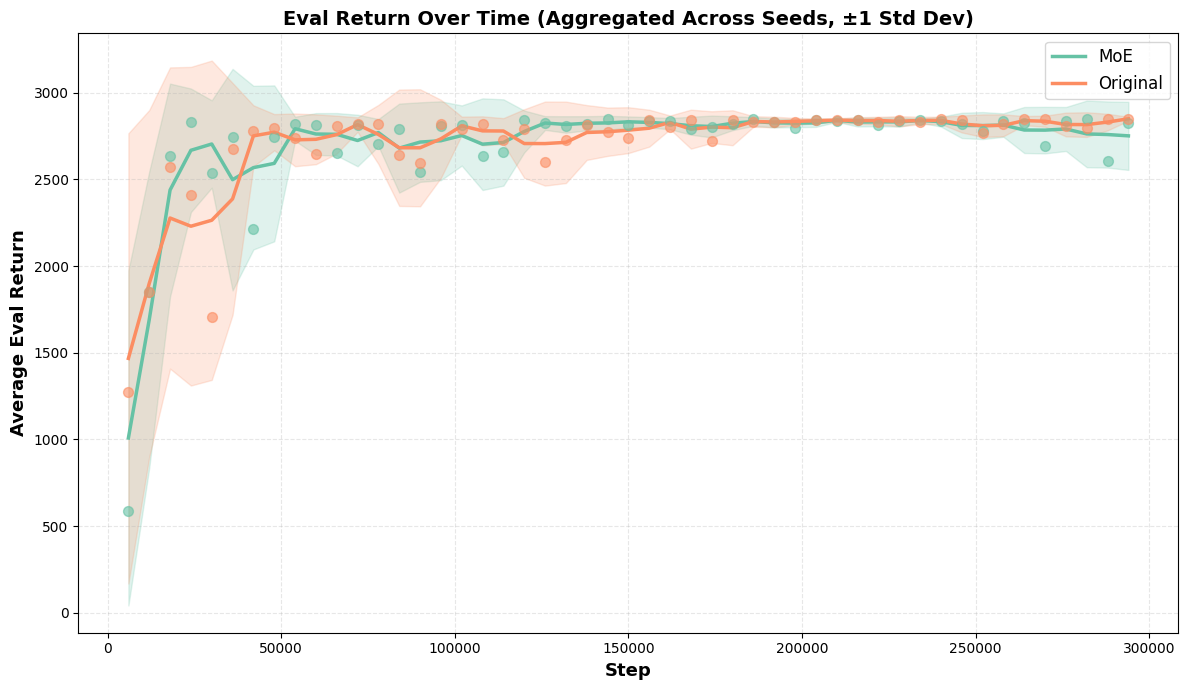

✓ Saved plot: results/individual_seeds_comparison_remove_lowest.png


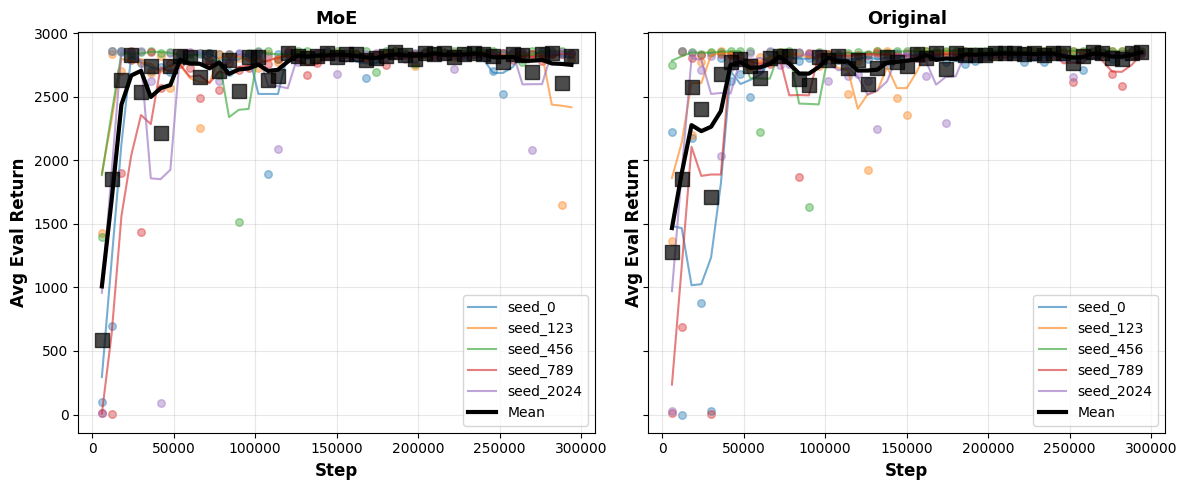

✓ Saved plot: results/cross_seed_eval_success_comparison_remove_lowest.png


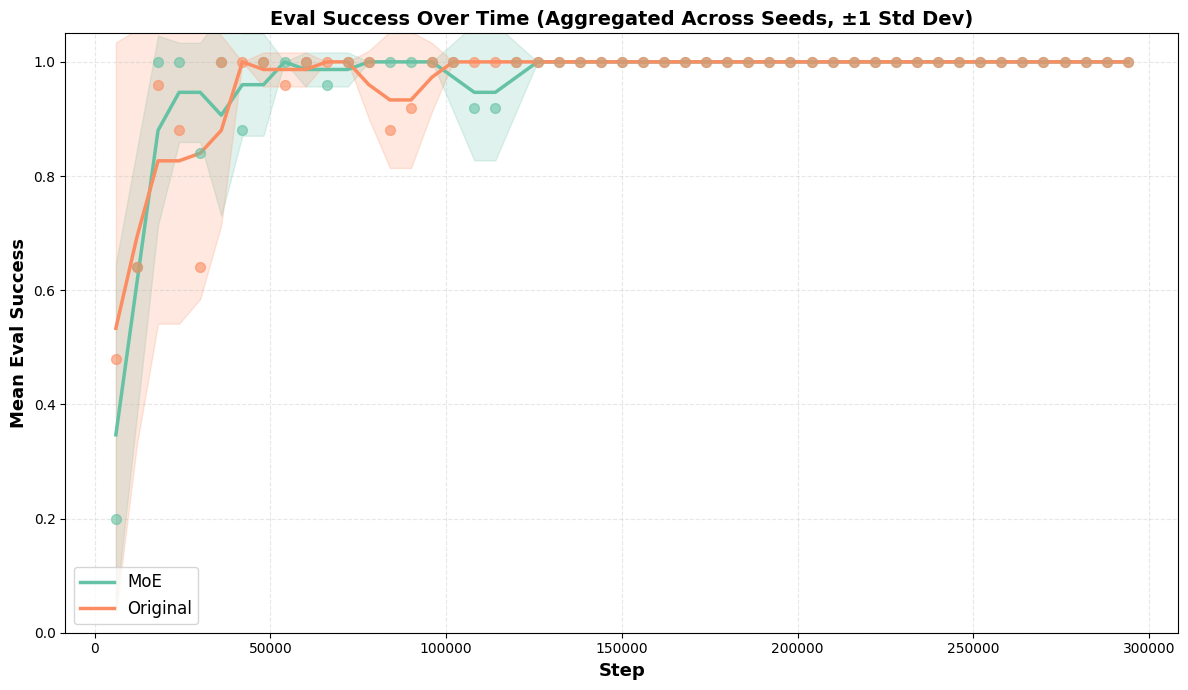

✓ Saved plot: results/individual_seeds_success_comparison_remove_lowest.png


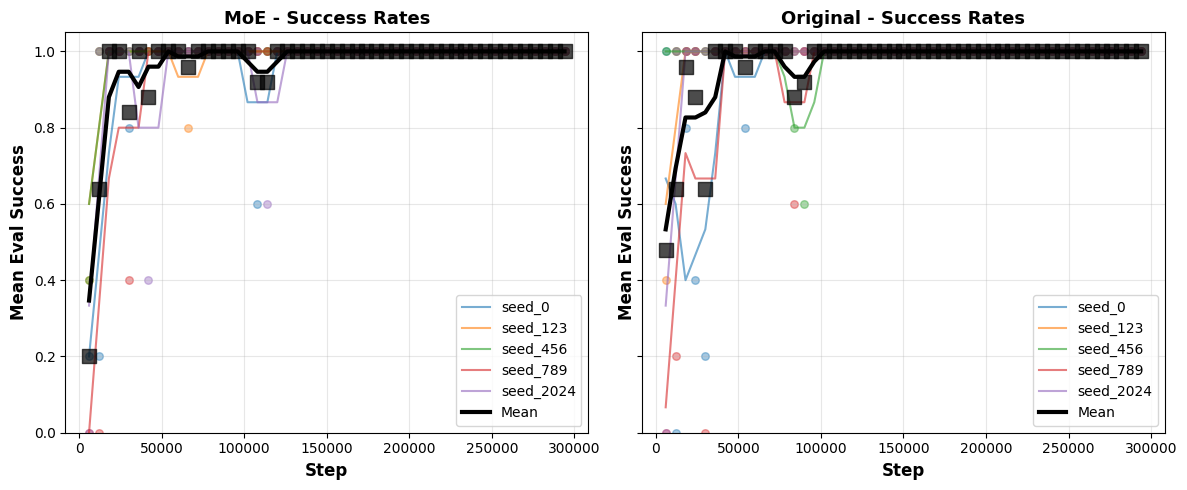

✓ Saved plot: results/variance_trend_eval_return_remove_lowest.png


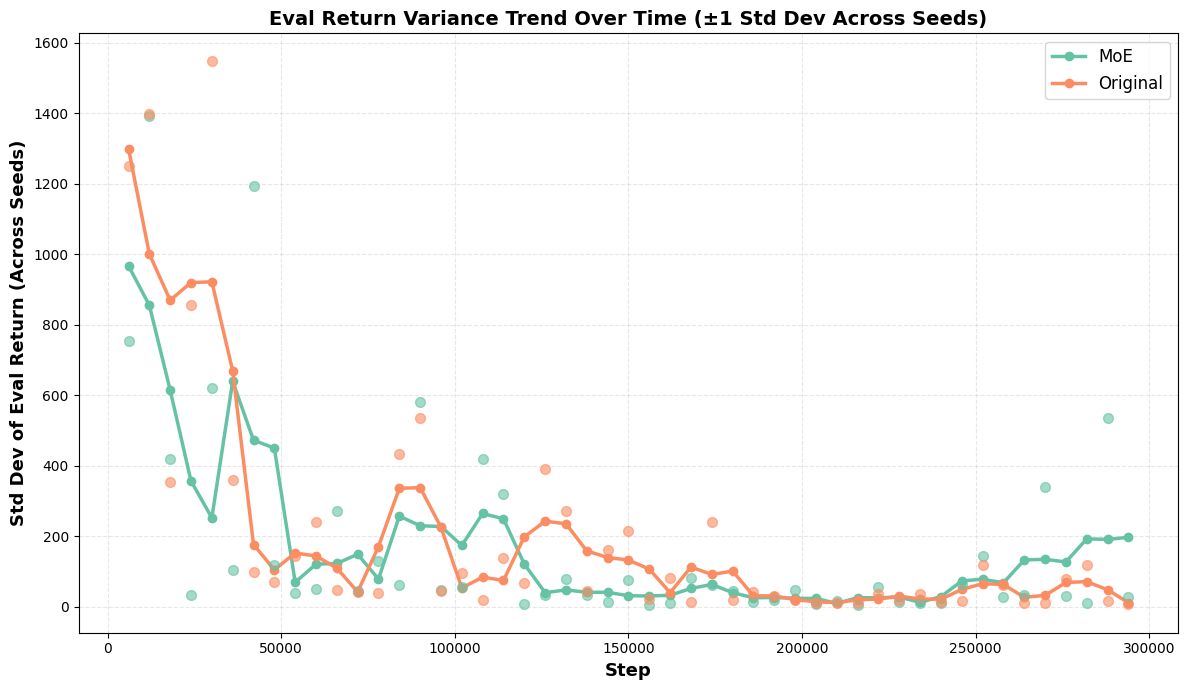

✓ Saved plot: results/variance_trend_eval_success_remove_lowest.png


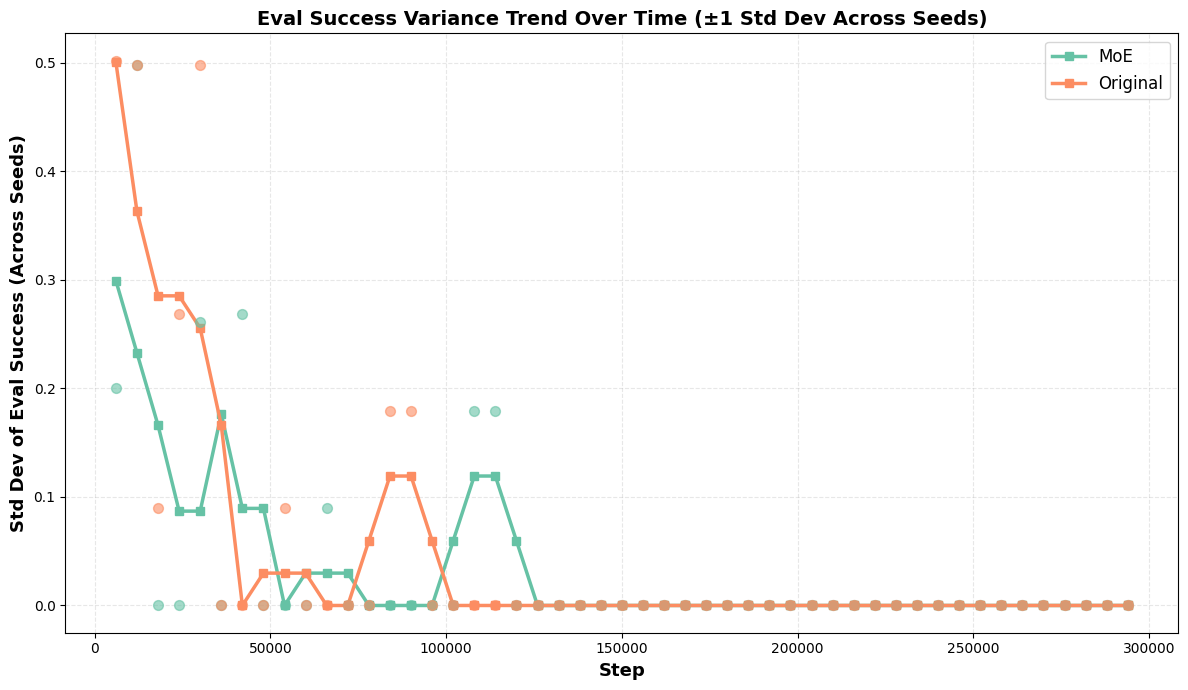

✓ Saved plot: results/variance_trend_combined_remove_lowest.png


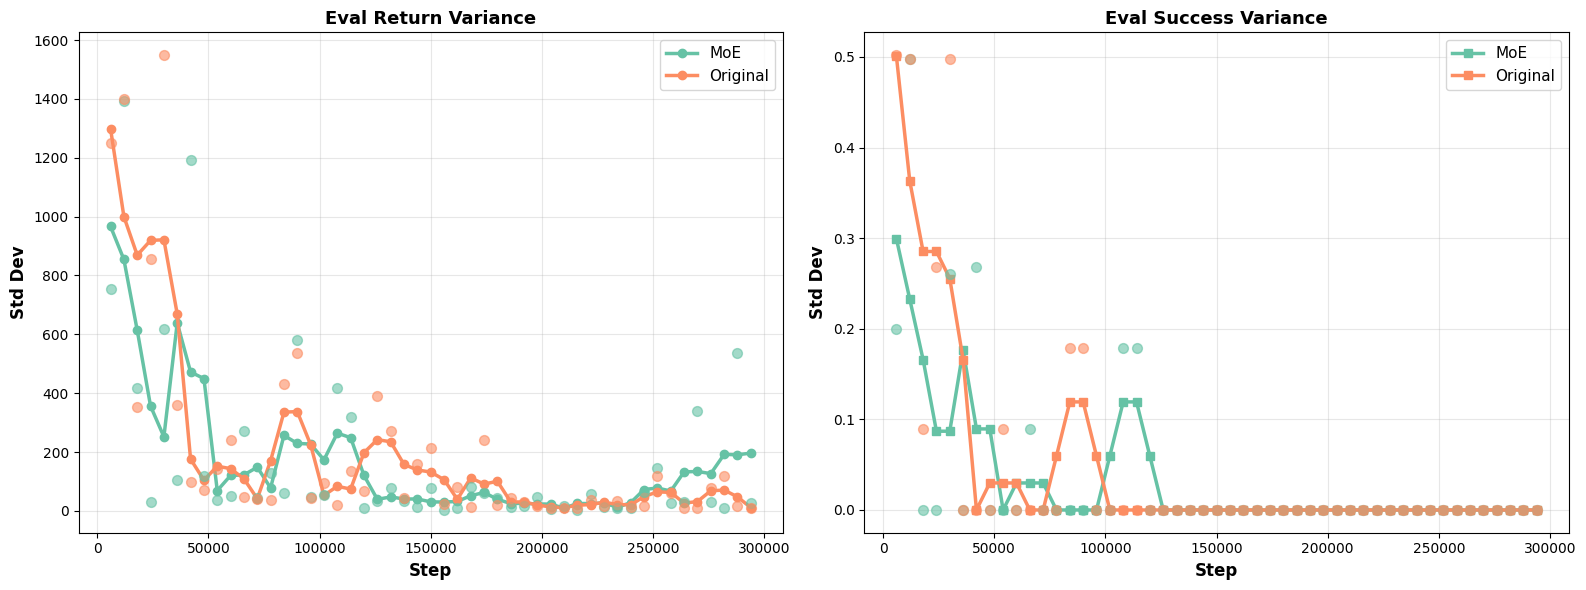


SUMMARY STATISTICS (Aggregated Across Seeds)

MoE:
  - Number of seeds: 5
  - Number of evaluation steps: 49
  - Final mean_eval_return: 2824.0998
  - Final std_eval_return: 26.9779
  - Max mean_eval_return: 2849.9940
  - Min mean_eval_return: 587.5930
  - Overall mean_eval_return: 2707.5950
  - Final mean_eval_success: 1.0000
  - Final std_eval_success: 0.0000
  - Max mean_eval_success: 1.0000
  - Min mean_eval_success: 0.2000
  - Overall mean_eval_success: 0.9665

Original:
  - Number of seeds: 5
  - Number of evaluation steps: 49
  - Final mean_eval_return: 2851.7410
  - Final std_eval_return: 8.4648
  - Max mean_eval_return: 2851.7410
  - Min mean_eval_return: 1276.0117
  - Overall mean_eval_return: 2706.4022
  - Final mean_eval_success: 1.0000
  - Final std_eval_success: 0.0000
  - Max mean_eval_success: 1.0000
  - Min mean_eval_success: 0.4800
  - Overall mean_eval_success: 0.9665

✓ All processing complete!


In [8]:
# Define your experiment paths
experiment_paths = {
    'MoE': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner2/moe_seed*",
    'Original': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/camera_corner2/original_seed*",
}

# Run with all parameters
results = analyze_metrics(
    experiment_paths=experiment_paths,
    output_dir='results',
    smoothness=3,          # 3=minimal, 5=default, 7-9=more, 11+=heavy
    remove_lowest=True    # True to remove lowest score per step
)

# Drawer close 25% student size

MULTI-SEED EVALUATION METRICS AGGREGATOR
Mode: REMOVE LOWEST SCORE
Smoothness: 3

📊 Processing experiment: MoE
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/smaller_student25/moe_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0... (removing lowest score)
    ✓ Processed 27 evaluation steps
  Processing seed 123... (removing lowest score)
    ✓ Processed 24 evaluation steps
  Processing seed 456... (removing lowest score)
    ✓ Processed 24 evaluation steps
  Processing seed 789... (removing lowest score)
    ✓ Processed 24 evaluation steps
  Processing seed 2024... (removing lowest score)
    ✓ Processed 24 evaluation steps
   ✓ Successfully processed 5 seed(s)

📊 Processing experiment: Original
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/smaller_student25/original_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0... (removing lowest score)
    ✓ Processed 28 evaluation 

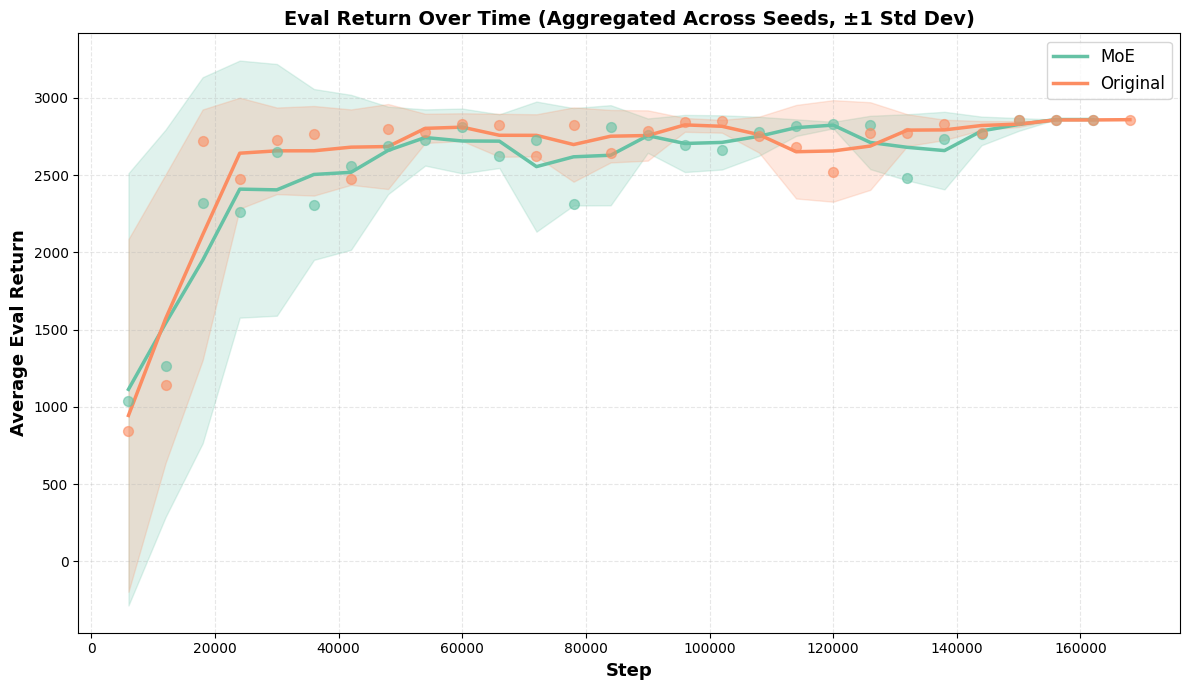

✓ Saved plot: results/individual_seeds_comparison_remove_lowest.png


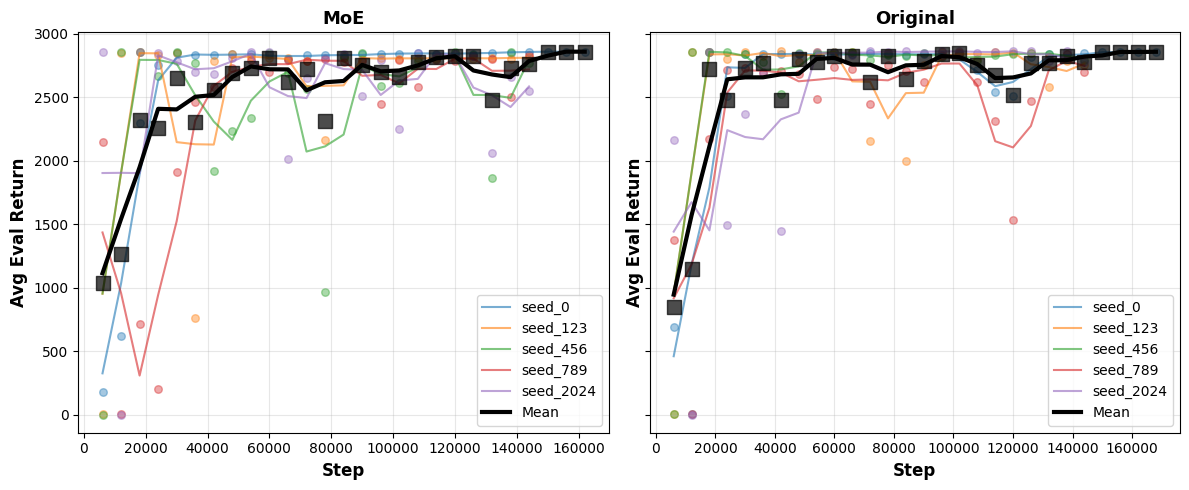

✓ Saved plot: results/cross_seed_eval_success_comparison_remove_lowest.png


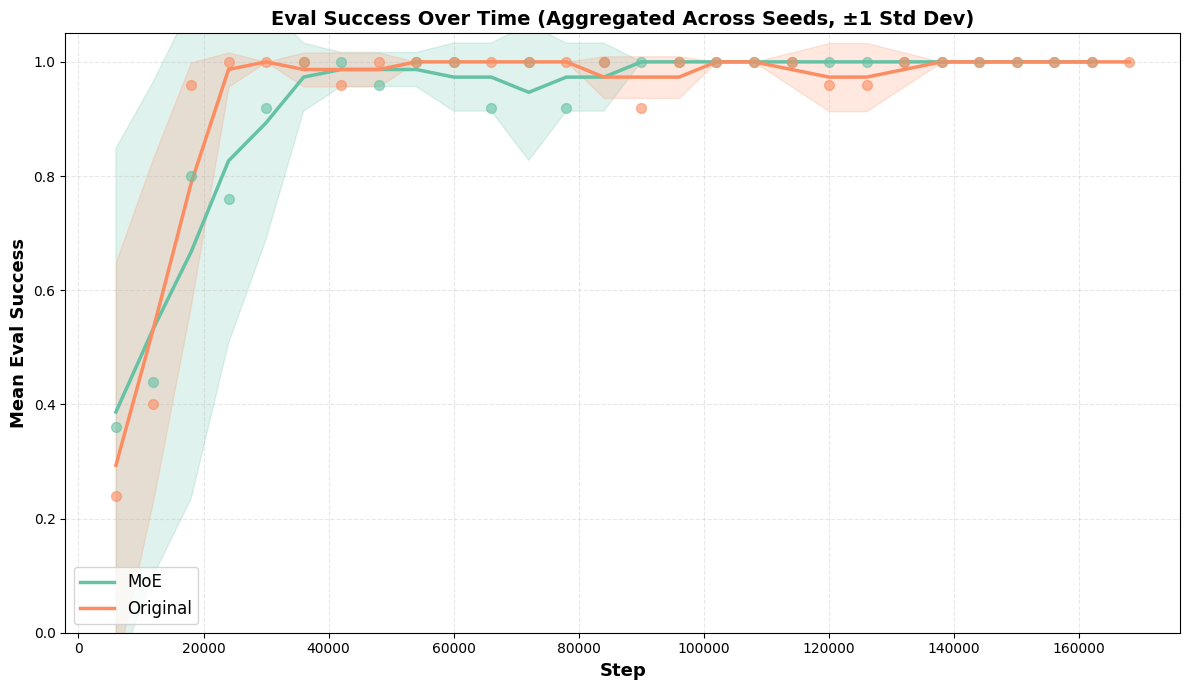

✓ Saved plot: results/individual_seeds_success_comparison_remove_lowest.png


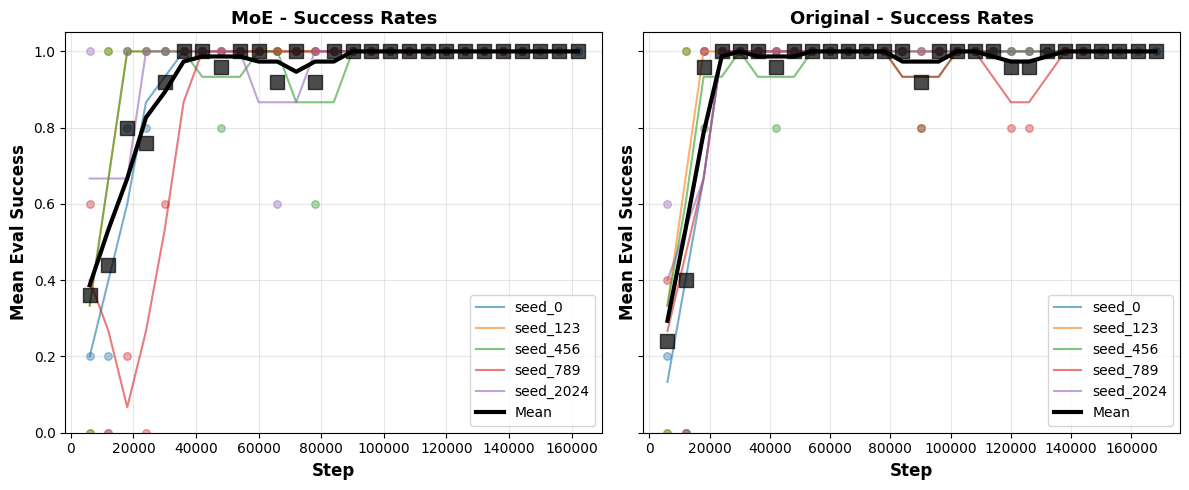

✓ Saved plot: results/variance_trend_eval_return_remove_lowest.png


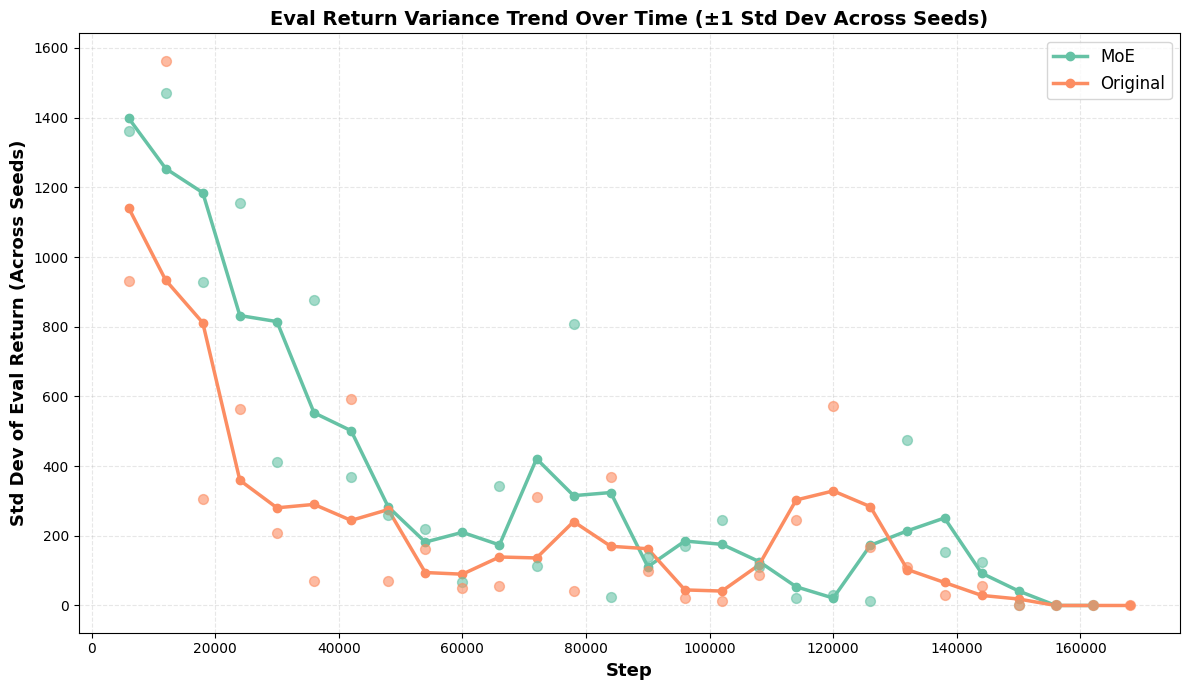

✓ Saved plot: results/variance_trend_eval_success_remove_lowest.png


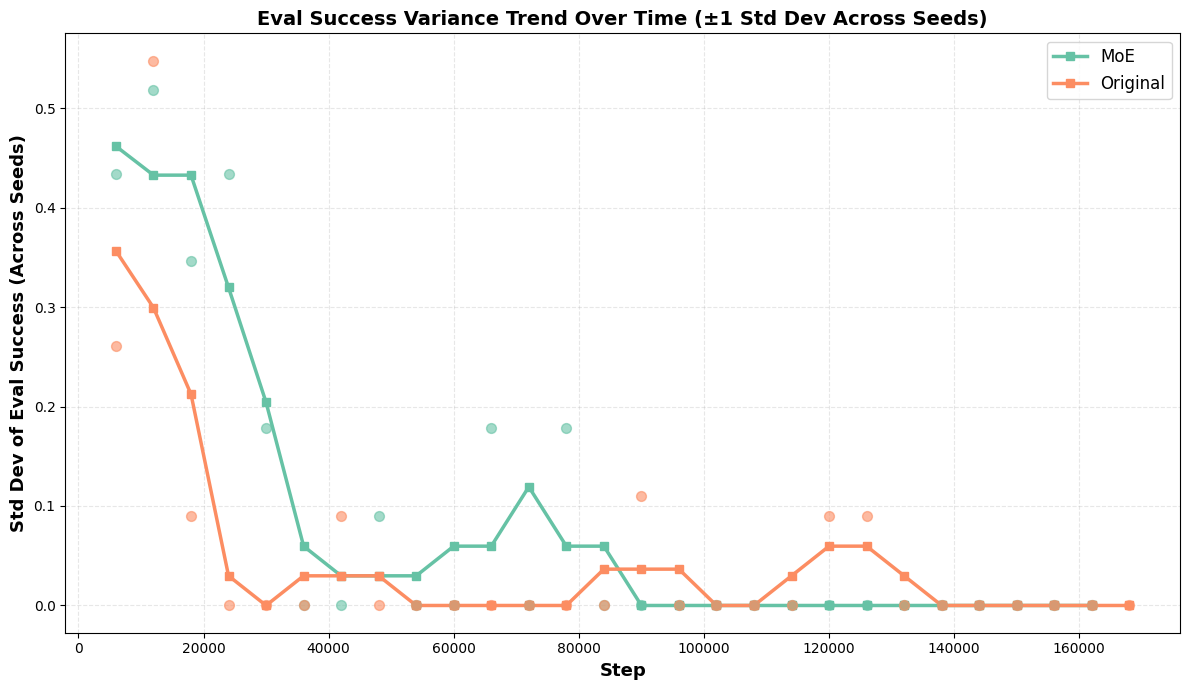

✓ Saved plot: results/variance_trend_combined_remove_lowest.png


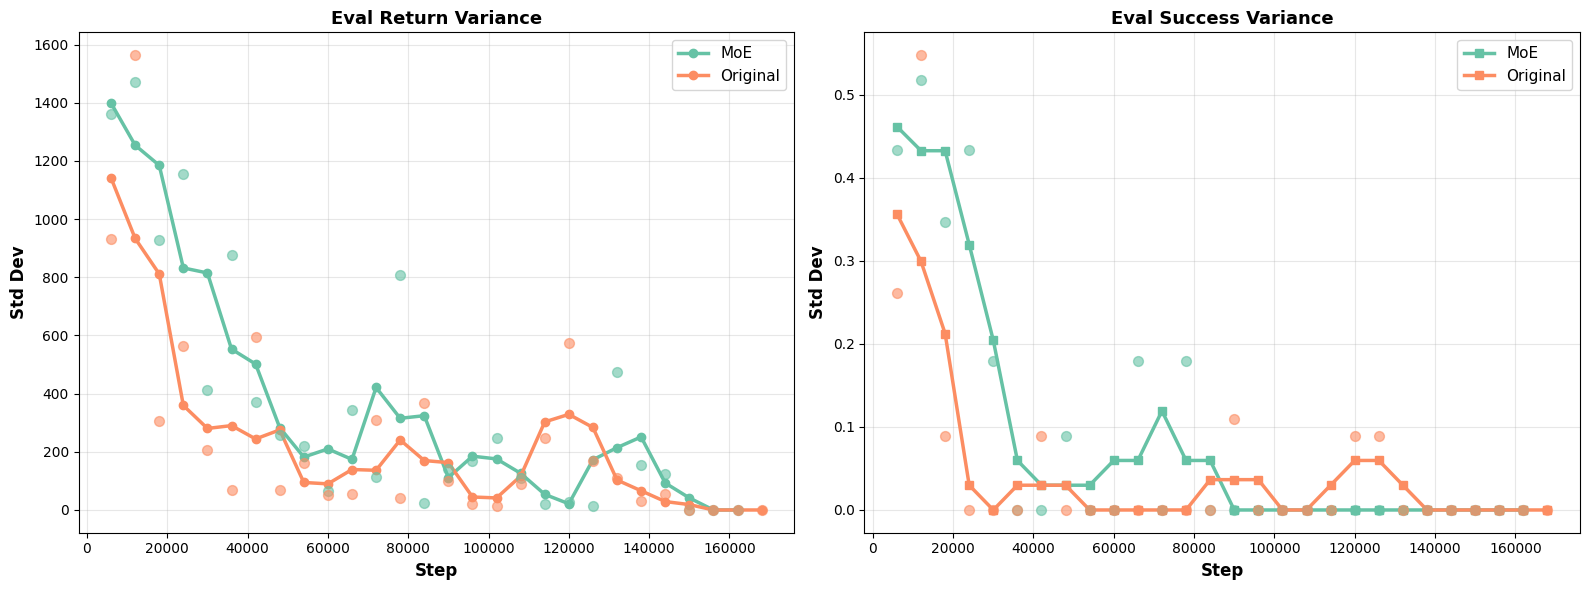


SUMMARY STATISTICS (Aggregated Across Seeds)

MoE:
  - Number of seeds: 5
  - Number of evaluation steps: 27
  - Final mean_eval_return: 2860.0000
  - Final std_eval_return: 0.0000
  - Max mean_eval_return: 2860.0000
  - Min mean_eval_return: 1036.5391
  - Overall mean_eval_return: 2556.7153
  - Final mean_eval_success: 1.0000
  - Final std_eval_success: 0.0000
  - Max mean_eval_success: 1.0000
  - Min mean_eval_success: 0.3600
  - Overall mean_eval_success: 0.9289

Original:
  - Number of seeds: 5
  - Number of evaluation steps: 28
  - Final mean_eval_return: 2860.0000
  - Final std_eval_return: 0.0000
  - Max mean_eval_return: 2860.0000
  - Min mean_eval_return: 844.9741
  - Overall mean_eval_return: 2625.0451
  - Final mean_eval_success: 1.0000
  - Final std_eval_success: 0.0000
  - Max mean_eval_success: 1.0000
  - Min mean_eval_success: 0.2400
  - Overall mean_eval_success: 0.9429

✓ All processing complete!


In [9]:
# Define your experiment paths
experiment_paths = {
    'MoE': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/smaller_student25/moe_seed*",
    'Original': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/smaller_student25/original_seed*",
}

# Run with all parameters
results = analyze_metrics(
    experiment_paths=experiment_paths,
    output_dir='results',
    smoothness=3,          # 3=minimal, 5=default, 7-9=more, 11+=heavy
    remove_lowest=True    # True to remove lowest score per step
)

# Drawer close 50% student size

MULTI-SEED EVALUATION METRICS AGGREGATOR
Mode: REMOVE LOWEST SCORE
Smoothness: 3

📊 Processing experiment: MoE
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/smaller_student50/moe_seed*
   ✓ Found 4 seed(s): [123, 456, 789, 2024]
  Processing seed 123... (removing lowest score)
    ✓ Processed 24 evaluation steps
  Processing seed 456... (removing lowest score)
    ✓ Processed 24 evaluation steps
  Processing seed 789... (removing lowest score)
    ✓ Processed 24 evaluation steps
  Processing seed 2024... (removing lowest score)
    ✓ Processed 24 evaluation steps
   ✓ Successfully processed 4 seed(s)

📊 Processing experiment: Original
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/smaller_student50/original_seed*
   ✓ Found 4 seed(s): [123, 456, 789, 2024]
  Processing seed 123... (removing lowest score)
    ✓ Processed 24 evaluation steps
  Processing seed 456... (removing lowest score)
    ✓ Processed 24 evaluation st

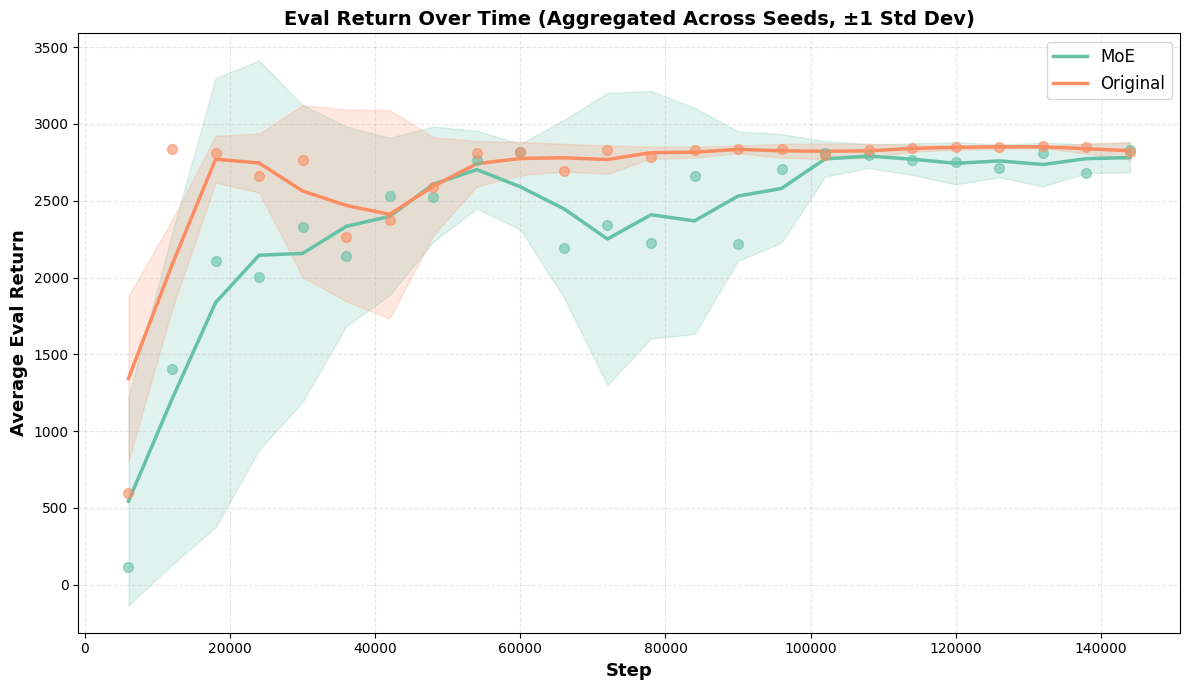

✓ Saved plot: results/individual_seeds_comparison_remove_lowest.png


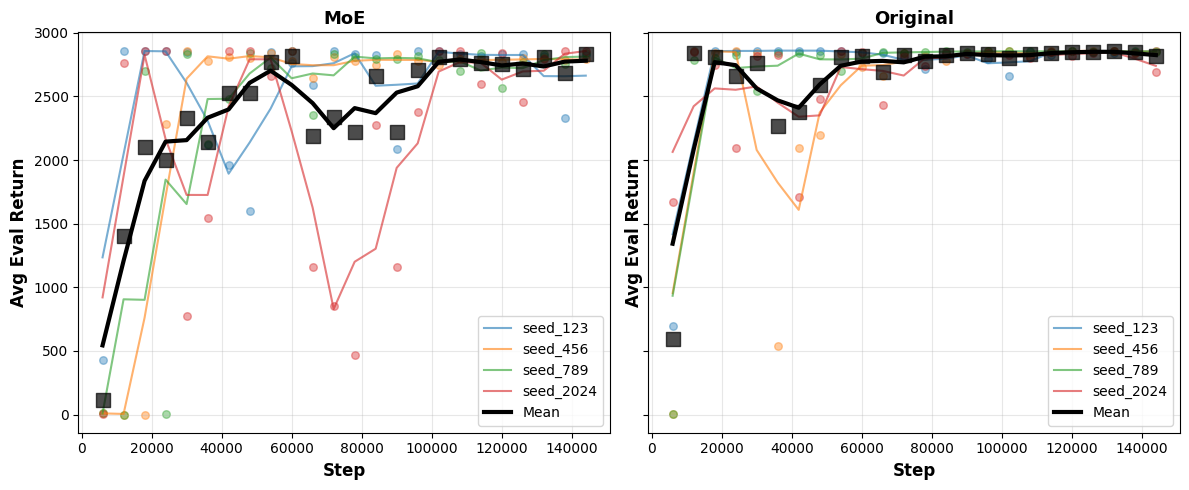

✓ Saved plot: results/cross_seed_eval_success_comparison_remove_lowest.png


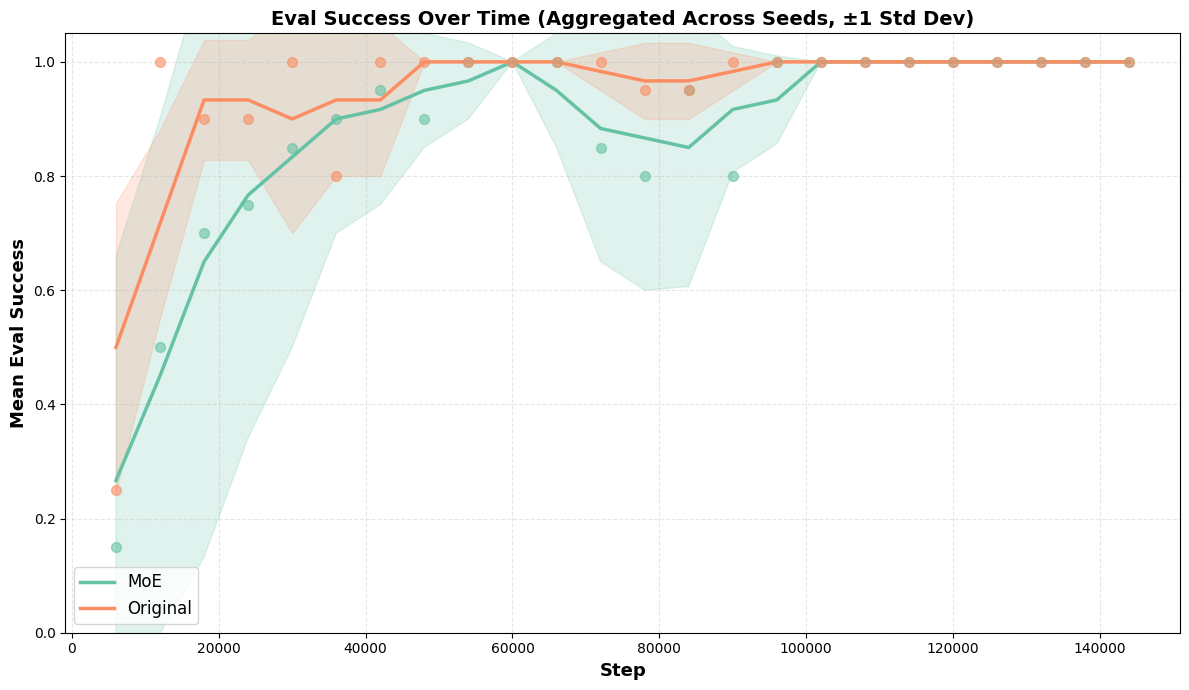

✓ Saved plot: results/individual_seeds_success_comparison_remove_lowest.png


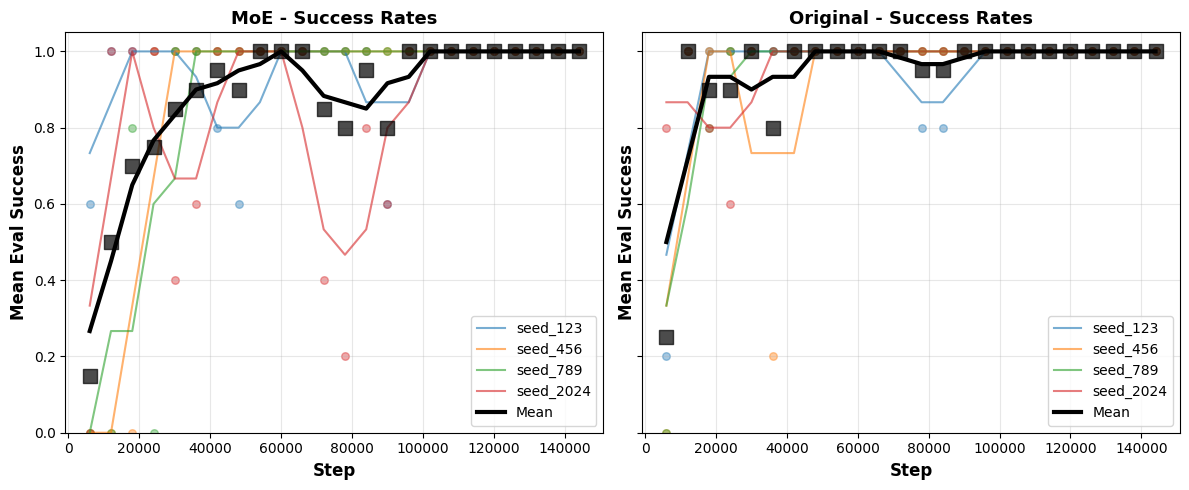

✓ Saved plot: results/variance_trend_eval_return_remove_lowest.png


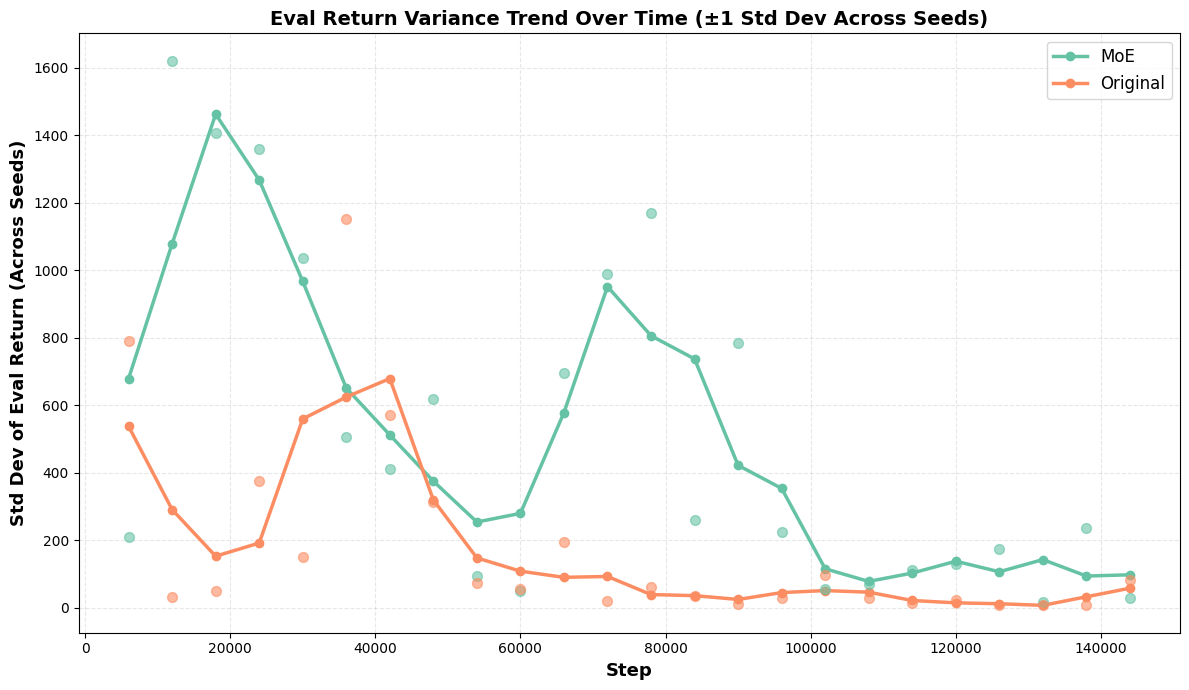

✓ Saved plot: results/variance_trend_eval_success_remove_lowest.png


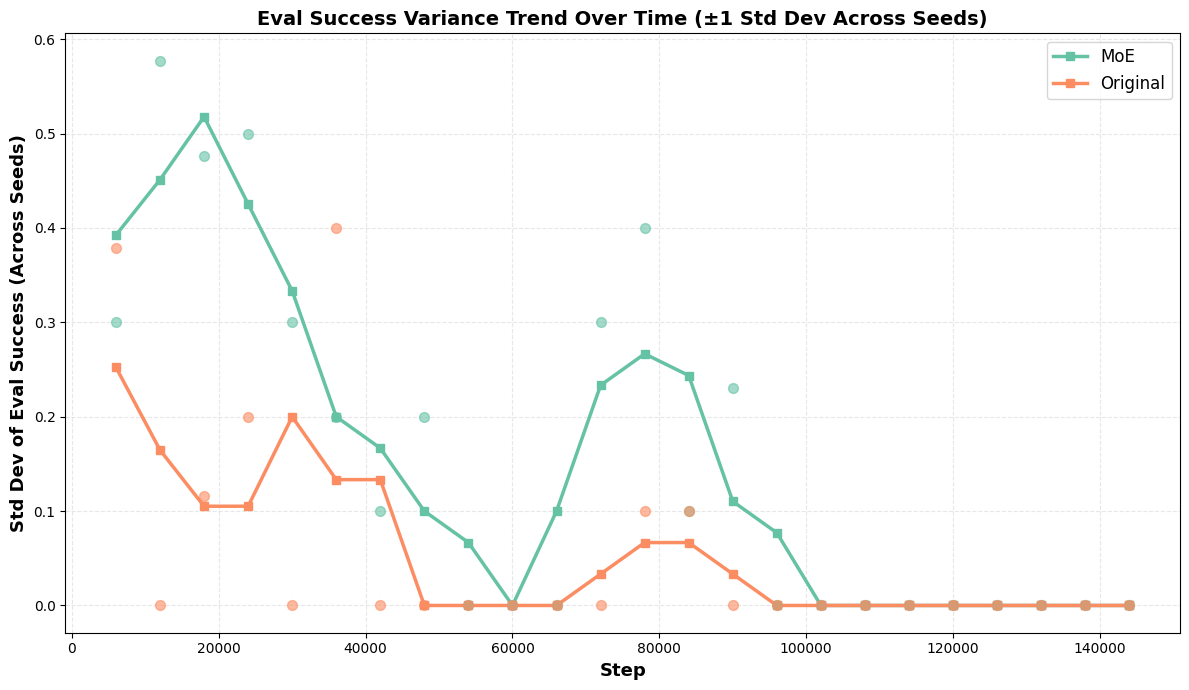

✓ Saved plot: results/variance_trend_combined_remove_lowest.png


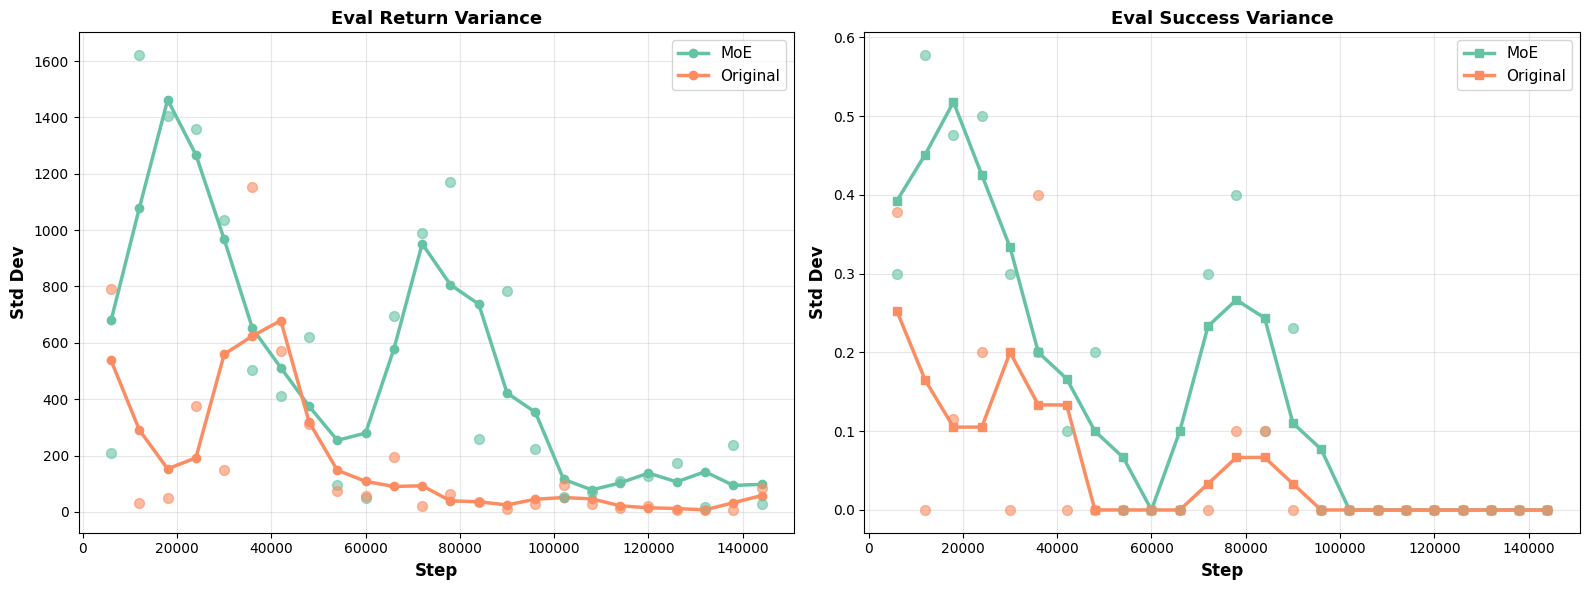


SUMMARY STATISTICS (Aggregated Across Seeds)

MoE:
  - Number of seeds: 4
  - Number of evaluation steps: 24
  - Final mean_eval_return: 2831.1474
  - Final std_eval_return: 28.1113
  - Max mean_eval_return: 2831.1474
  - Min mean_eval_return: 113.5548
  - Overall mean_eval_return: 2384.9012
  - Final mean_eval_success: 1.0000
  - Final std_eval_success: 0.0000
  - Max mean_eval_success: 1.0000
  - Min mean_eval_success: 0.1500
  - Overall mean_eval_success: 0.8792

Original:
  - Number of seeds: 4
  - Number of evaluation steps: 24
  - Final mean_eval_return: 2814.4416
  - Final std_eval_return: 83.0157
  - Max mean_eval_return: 2855.0554
  - Min mean_eval_return: 594.9550
  - Overall mean_eval_return: 2668.1467
  - Final mean_eval_success: 1.0000
  - Final std_eval_success: 0.0000
  - Max mean_eval_success: 1.0000
  - Min mean_eval_success: 0.2500
  - Overall mean_eval_success: 0.9479

✓ All processing complete!


In [10]:
# Define your experiment paths
experiment_paths = {
    'MoE': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/smaller_student50/moe_seed*",
    'Original': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/smaller_student50/original_seed*",
}

# Run with all parameters
results = analyze_metrics(
    experiment_paths=experiment_paths,
    output_dir='results',
    smoothness=3,          # 3=minimal, 5=default, 7-9=more, 11+=heavy
    remove_lowest=True    # True to remove lowest score per step
)

MULTI-SEED EVALUATION METRICS AGGREGATOR
Mode: KEEP ALL SCORES
Smoothness: 3

📊 Processing experiment: MoE
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/window_close/moe_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0...
    ✓ Processed 24 evaluation steps
  Processing seed 123...
    ✓ Processed 24 evaluation steps
  Processing seed 456...
    ✓ Processed 24 evaluation steps
  Processing seed 789...
    ✓ Processed 24 evaluation steps
  Processing seed 2024...
    ✓ Processed 24 evaluation steps
   ✓ Successfully processed 5 seed(s)

📊 Processing experiment: Original
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/window_close/original_seed*
   ⚠️  No seed directories found matching pattern!

✓ Successfully processed all experiments

Aggregating metrics across seeds...

MoE:
  - Seeds processed: 5
  - Evaluation steps: 24
  - Final mean_eval_return: 1848.30 ± 592.02
  - Final mean_eval_success: 0.8800 ± 0.2683

Saving ag

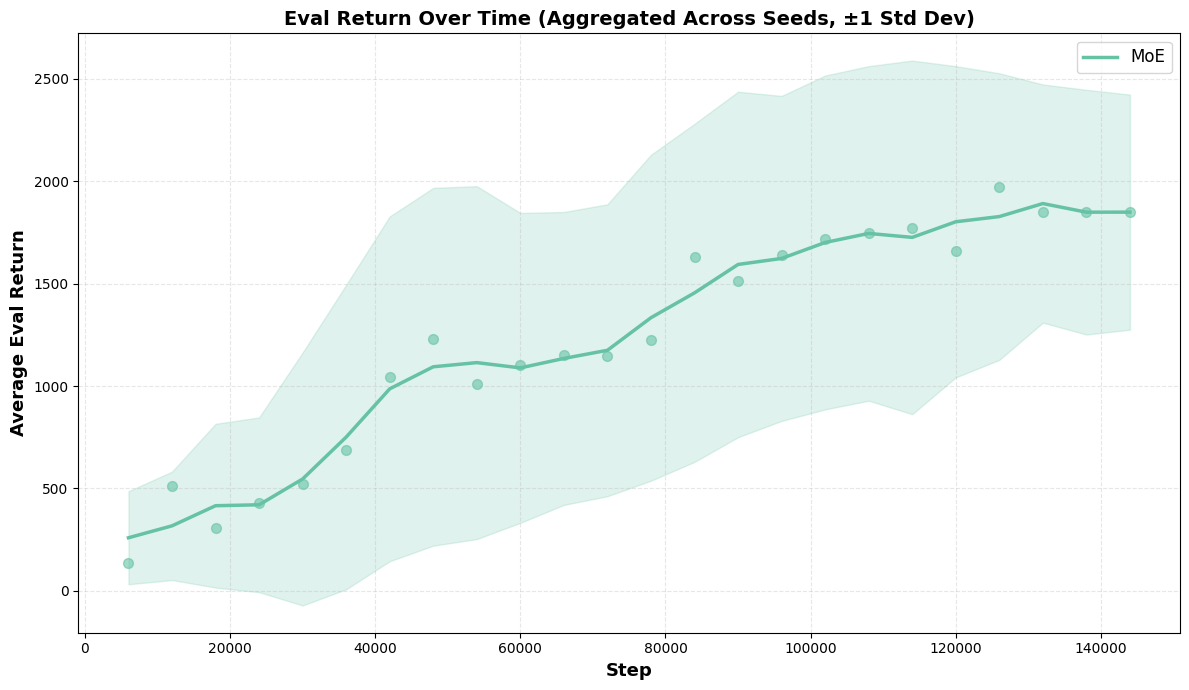

✓ Saved plot: results/individual_seeds_comparison_all_scores.png


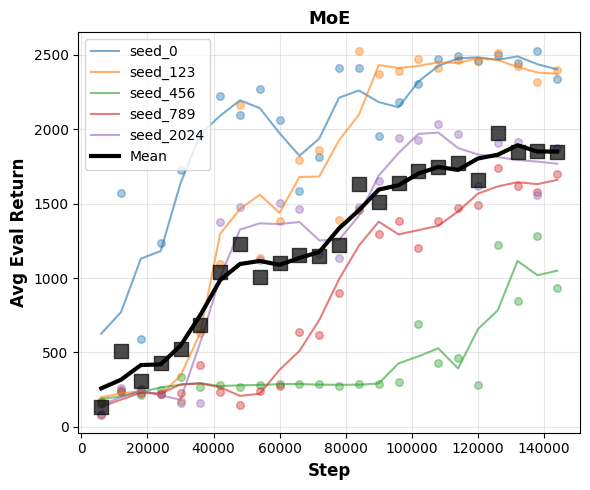

✓ Saved plot: results/cross_seed_eval_success_comparison_all_scores.png


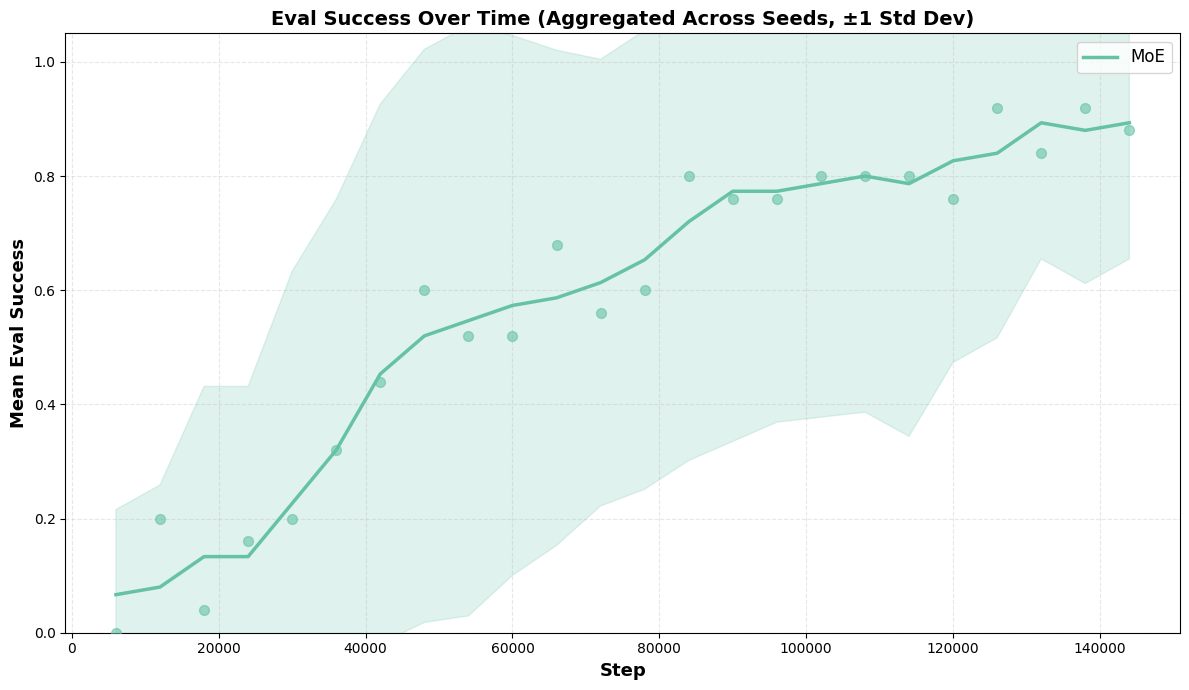

✓ Saved plot: results/individual_seeds_success_comparison_all_scores.png


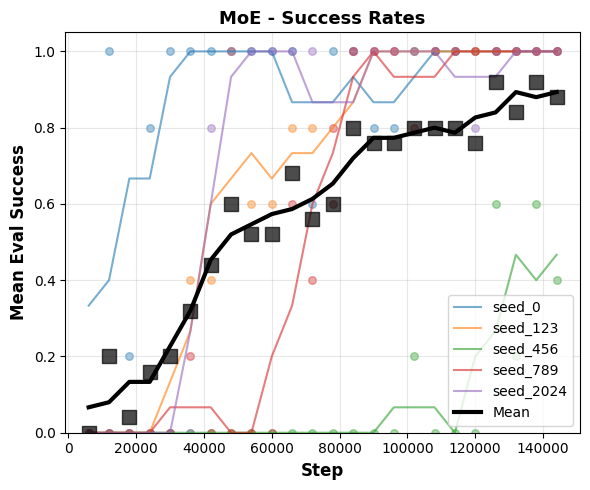

✓ Saved plot: results/variance_trend_eval_return_all_scores.png


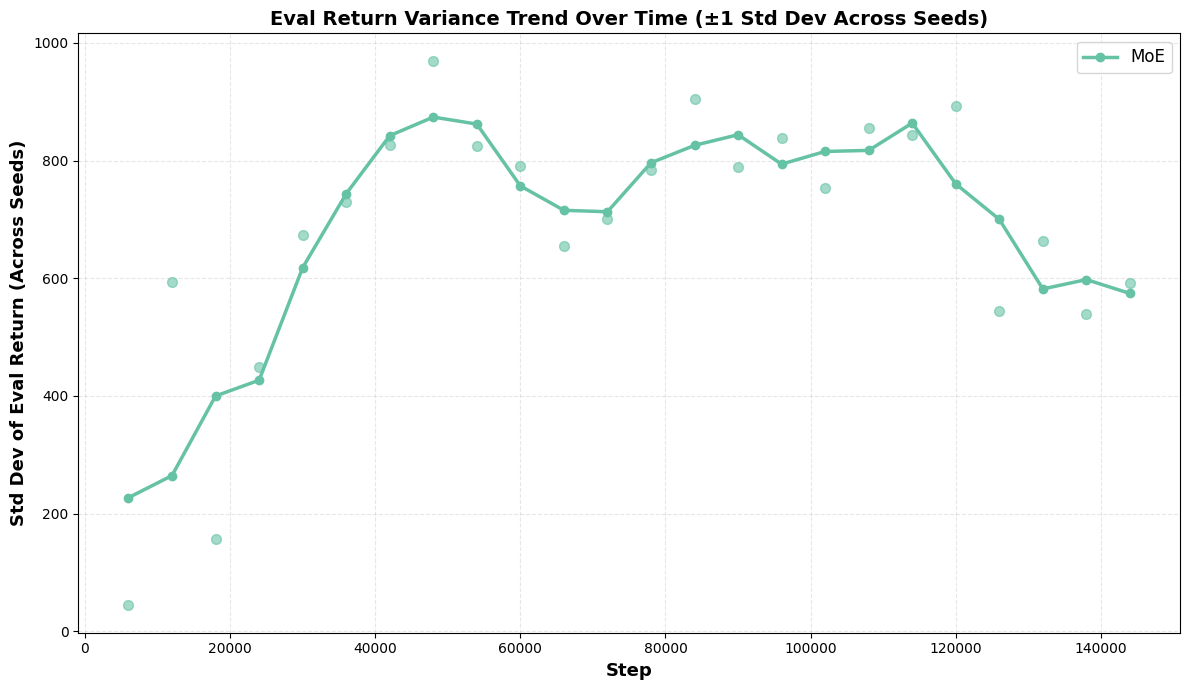

✓ Saved plot: results/variance_trend_eval_success_all_scores.png


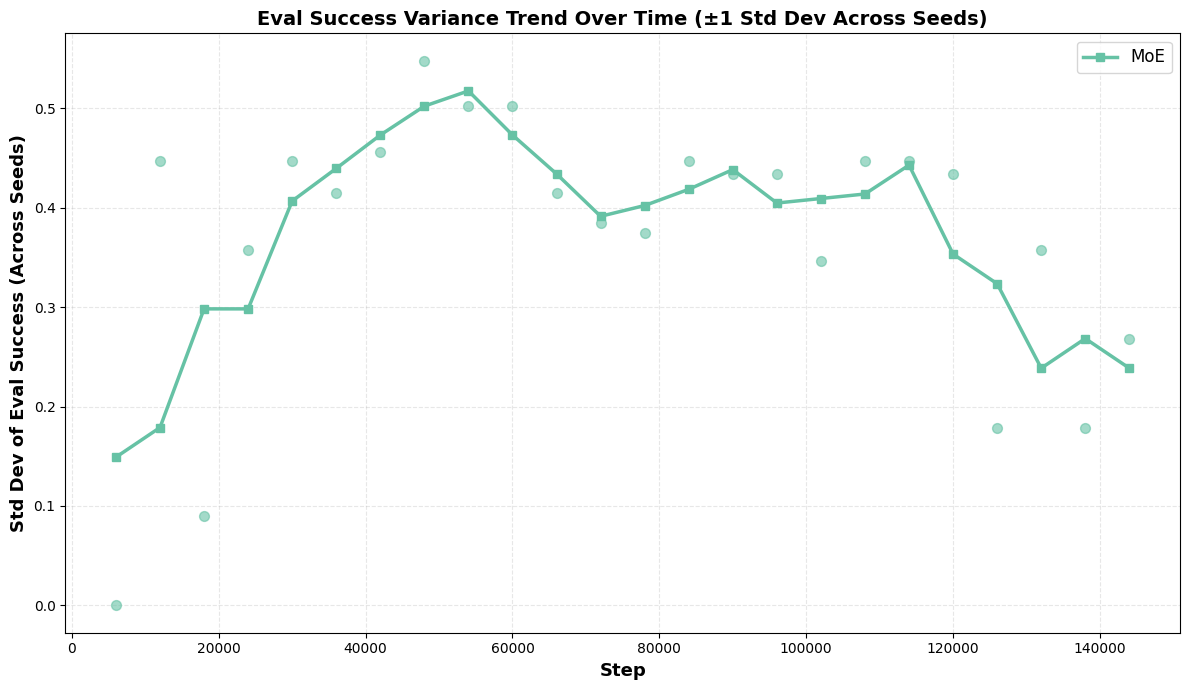

✓ Saved plot: results/variance_trend_combined_all_scores.png


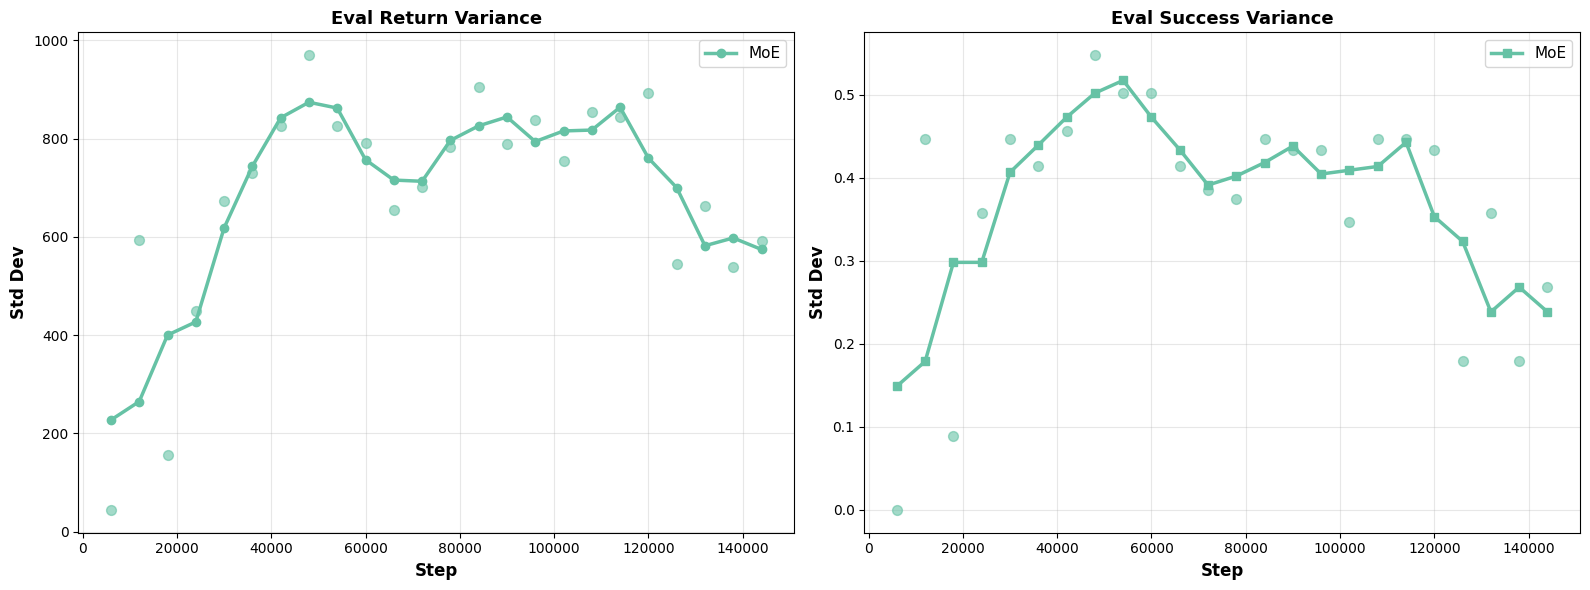


SUMMARY STATISTICS (Aggregated Across Seeds)

MoE:
  - Number of seeds: 5
  - Number of evaluation steps: 24
  - Final mean_eval_return: 1848.3030
  - Final std_eval_return: 592.0166
  - Max mean_eval_return: 1974.5797
  - Min mean_eval_return: 133.1465
  - Overall mean_eval_return: 1237.4403
  - Final mean_eval_success: 0.8800
  - Final std_eval_success: 0.2683
  - Max mean_eval_success: 0.9200
  - Min mean_eval_success: 0.0000
  - Overall mean_eval_success: 0.5783

✓ All processing complete!


In [11]:
# Define your experiment paths
experiment_paths = {
    'MoE': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/window_close/moe_seed*",
    'Original': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/window_close/original_seed*",
}

# Run with all parameters
results = analyze_metrics(
    experiment_paths=experiment_paths,
    output_dir='results',
    smoothness=3,          # 3=minimal, 5=default, 7-9=more, 11+=heavy
    remove_lowest=False    # True to remove lowest score per step
)

Available keys: ['image', 'action', 'reward', 'discount', 'success', 'is_first', 'is_last', 'is_terminal', 'logprob', 'task_id']
Episode length: 150
Image shape: (150, 64, 64, 3)
Action shape: (150, 4)
Total reward: 216.8824462890625


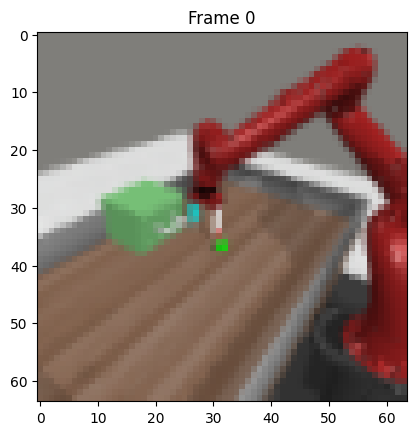

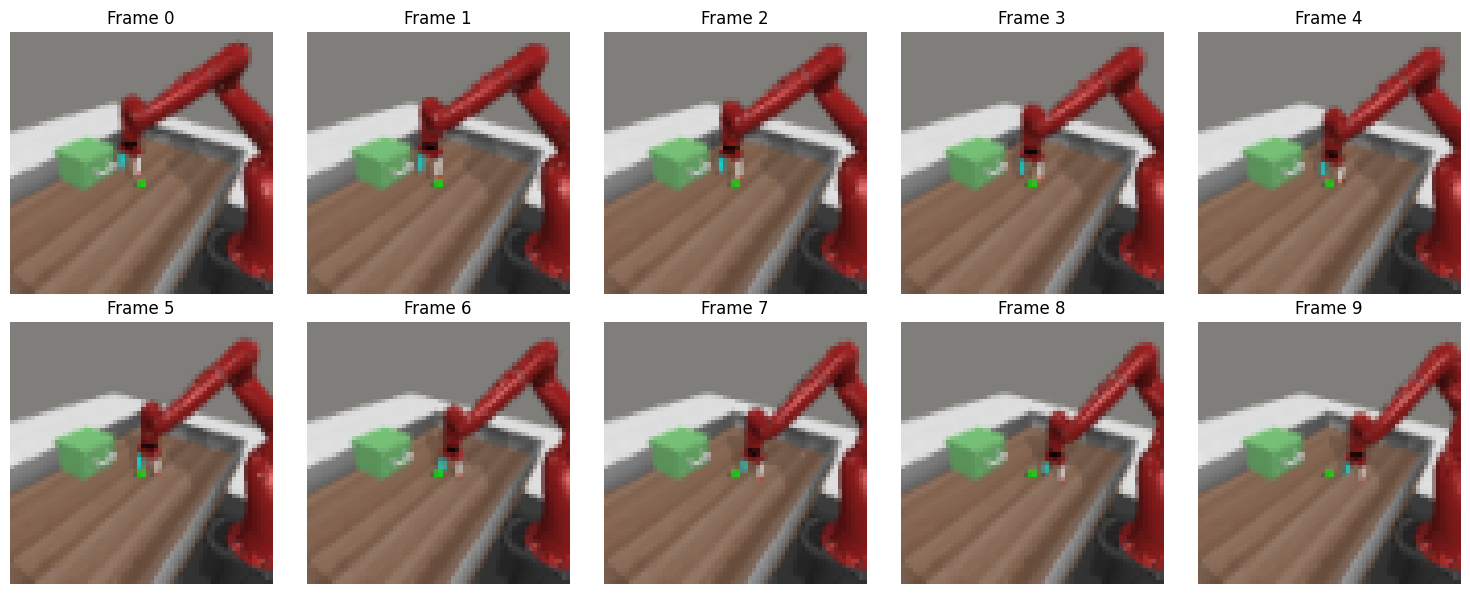

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Load the episode file
episode = np.load('/storage/ssd1/richtsai1103/iso_ted/log/metaworld/multi_5/mentor_open/dreamer_fixed-long_2/train_eps_by_task/task_1/20250926T021706-8cd1e5517f18480c9fb866ea3293e7f7.npz')

# See all available keys
print("Available keys:", episode.files)

# Access specific attributes
images = episode['image']  # Shape: (T, H, W, C) where T is episode length
actions = episode['action']
rewards = episode['reward']
discount = episode['discount']

print(f"Episode length: {len(rewards)}")
print(f"Image shape: {images.shape}")
print(f"Action shape: {actions.shape}")
print(f"Total reward: {rewards.sum()}")


# Display a single frame
plt.imshow(images[0])  # First frame
plt.title('Frame 0')
plt.show()

# Display multiple frames
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        ax.imshow(images[idx])
        ax.set_title(f'Frame {idx}')
        ax.axis('off')
plt.tight_layout()
plt.show()

MULTI-SEED EVALUATION METRICS AGGREGATOR
Mode: KEEP ALL SCORES
Smoothness: 3

📊 Processing experiment: MoE
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/new_moe/moe_multihead_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0...
    ✓ Processed 24 evaluation steps
  Processing seed 123...
    ✓ Processed 24 evaluation steps
  Processing seed 456...
    ✓ Processed 24 evaluation steps
  Processing seed 789...
    ✓ Processed 24 evaluation steps
  Processing seed 2024...
    ✓ Processed 24 evaluation steps
   ✓ Successfully processed 5 seed(s)

📊 Processing experiment: Original
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/new_moe/original_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0...
    ✓ Processed 24 evaluation steps
  Processing seed 123...
    ✓ Processed 24 evaluation steps
  Processing seed 456...
    ✓ Processed 24 evaluation steps
  Processing seed 789...
    ✓

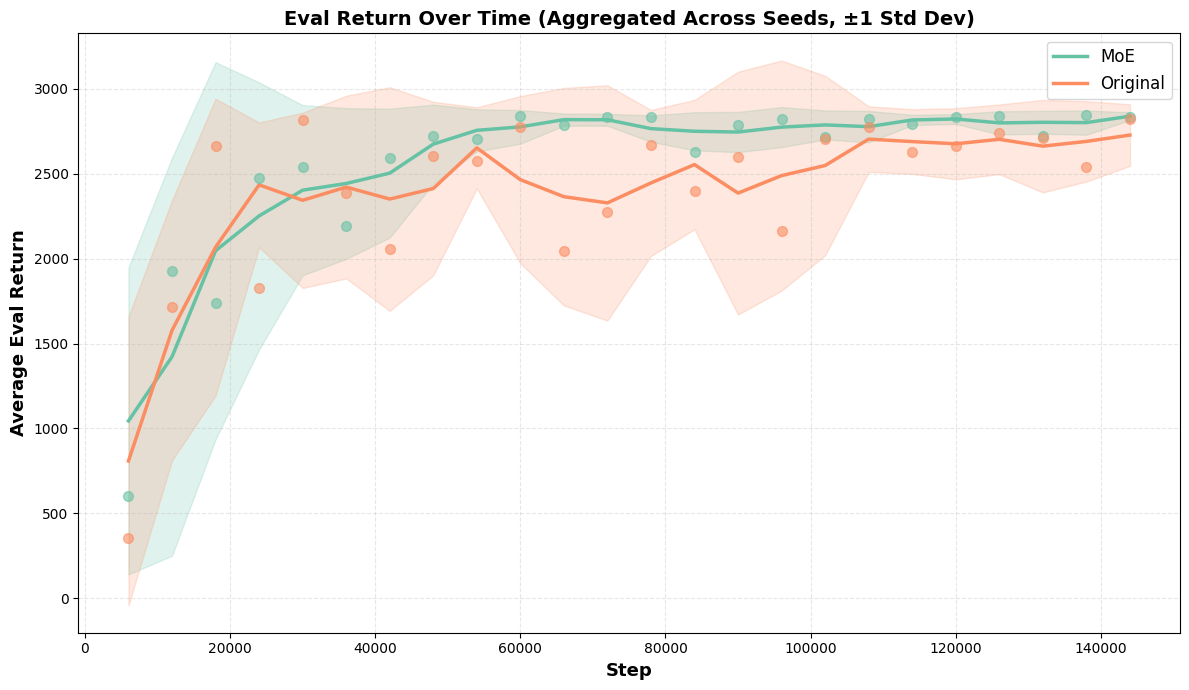

✓ Saved plot: results/individual_seeds_comparison_all_scores.png


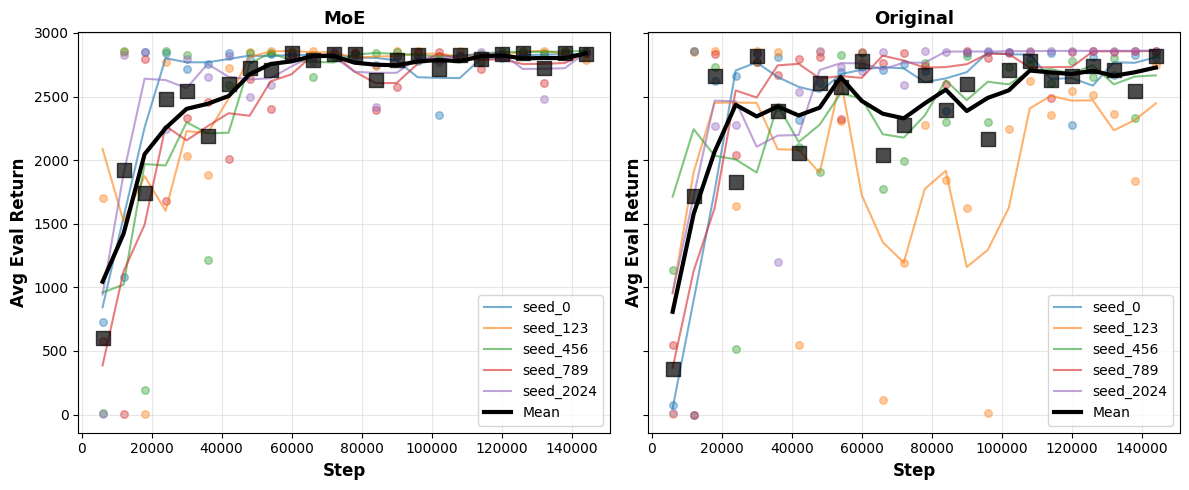

✓ Saved plot: results/cross_seed_eval_success_comparison_all_scores.png


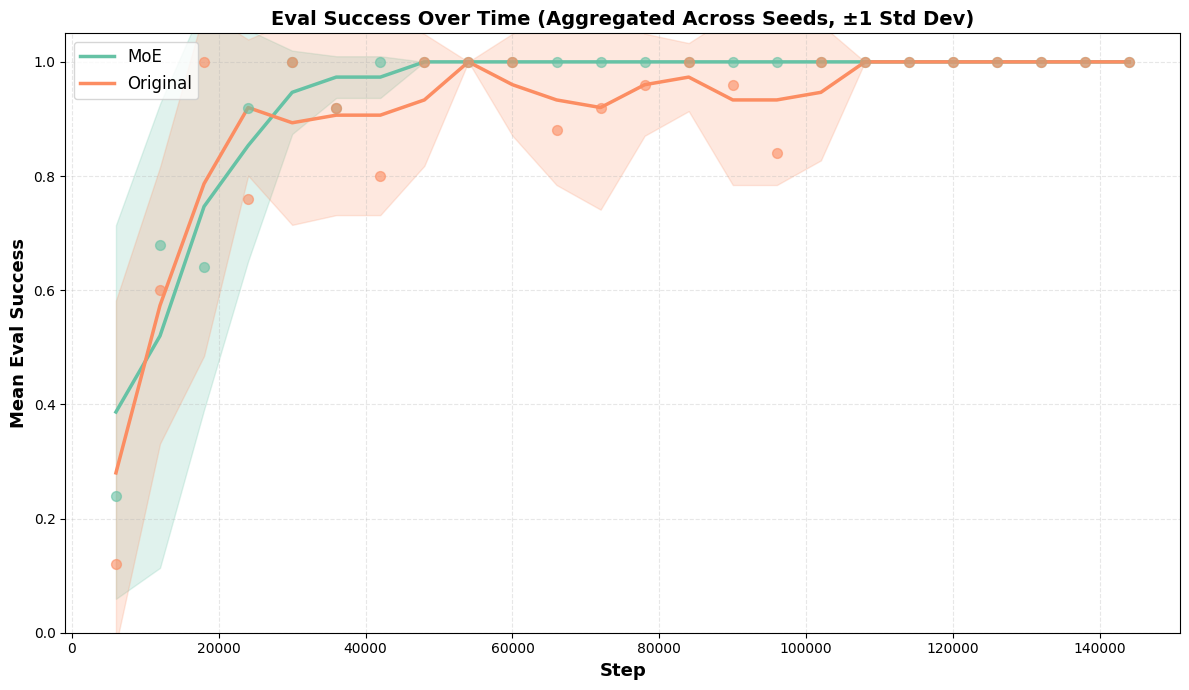

✓ Saved plot: results/individual_seeds_success_comparison_all_scores.png


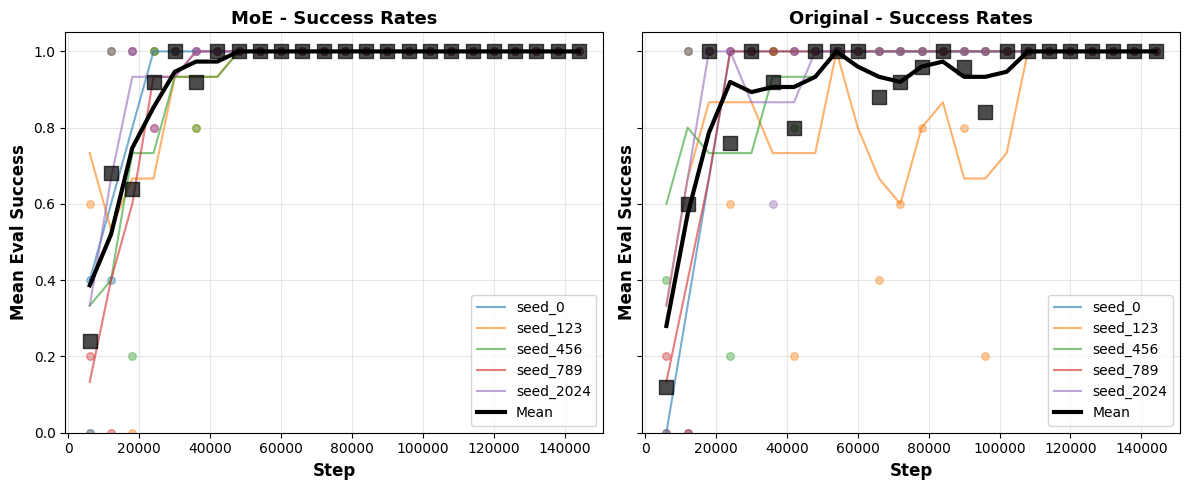

✓ Saved plot: results/variance_trend_eval_return_all_scores.png


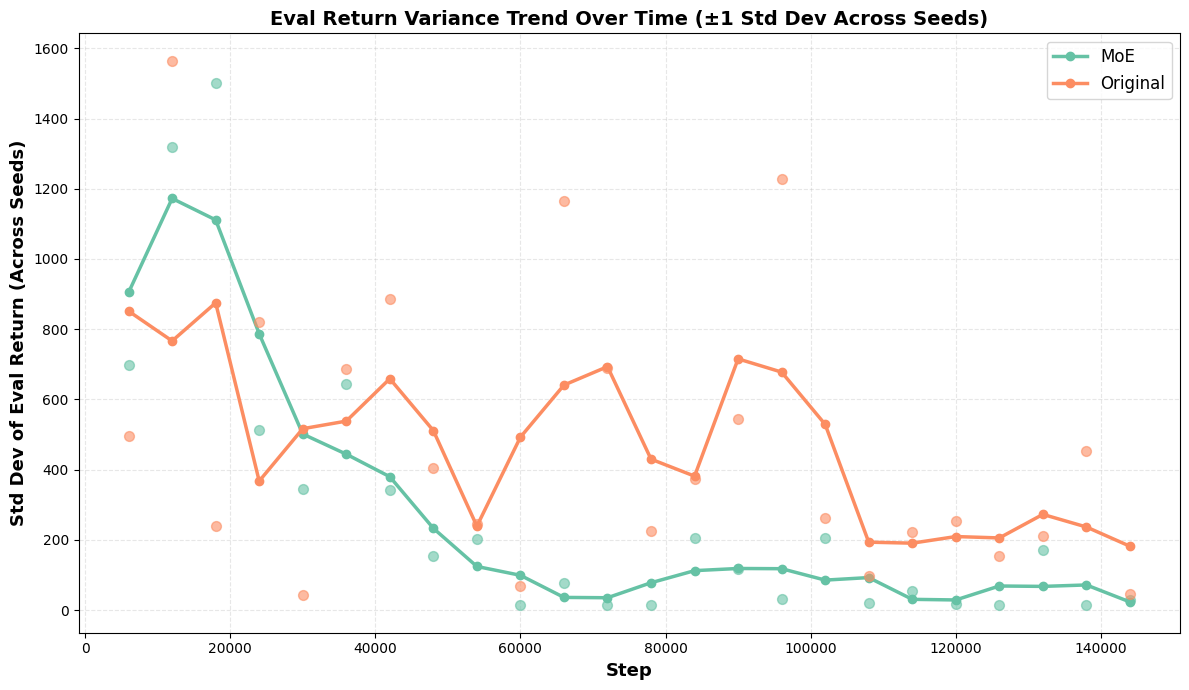

✓ Saved plot: results/variance_trend_eval_success_all_scores.png


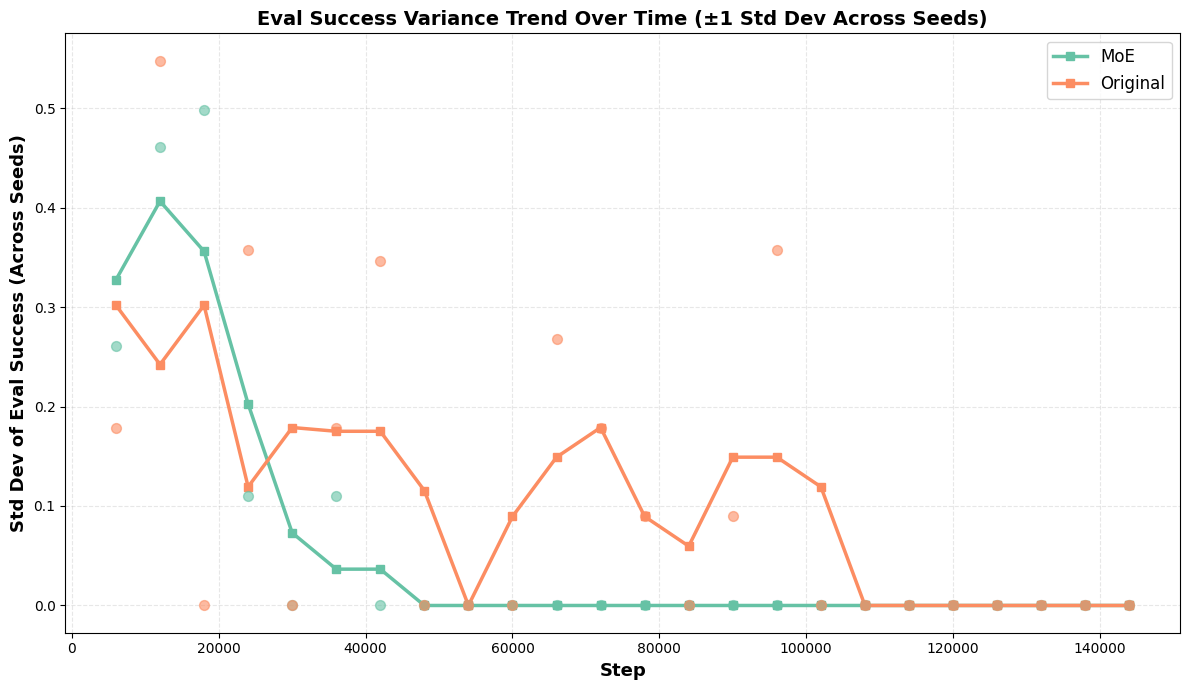

✓ Saved plot: results/variance_trend_combined_all_scores.png


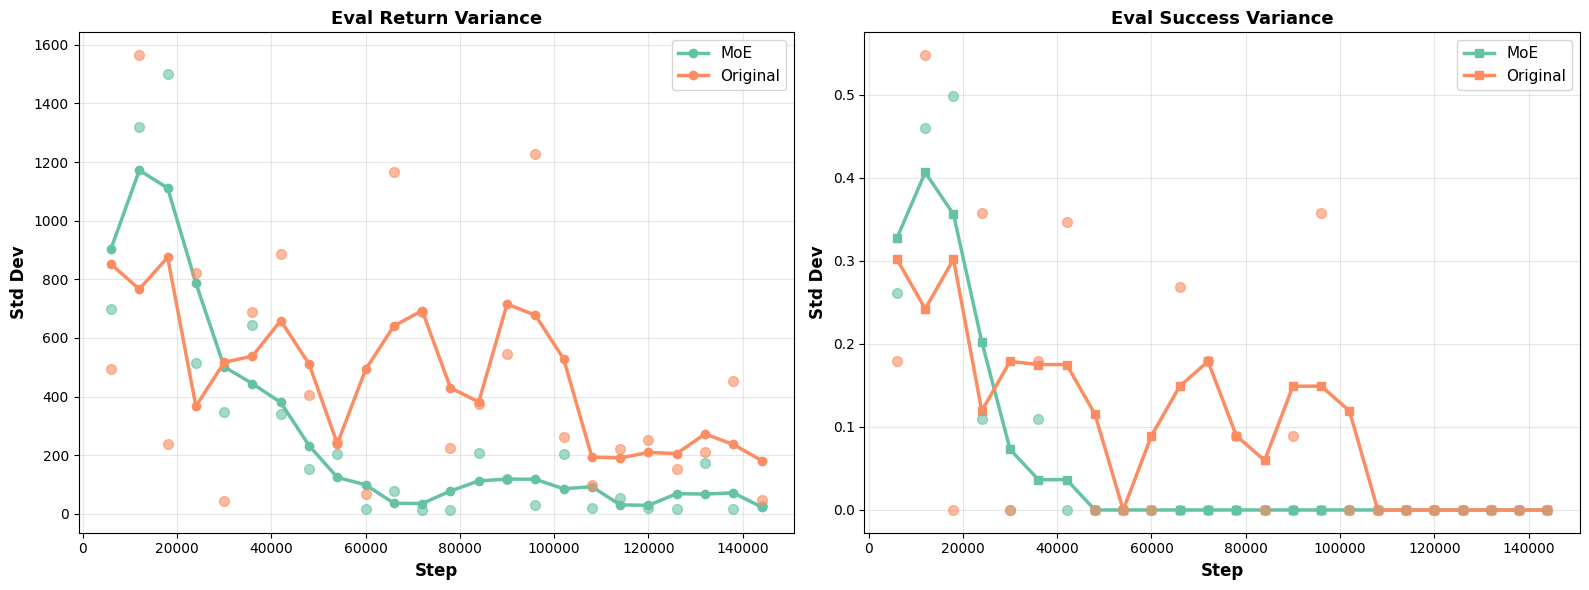


SUMMARY STATISTICS (Aggregated Across Seeds)

MoE:
  - Number of seeds: 5
  - Number of evaluation steps: 24
  - Final mean_eval_return: 2836.9075
  - Final std_eval_return: 27.2981
  - Max mean_eval_return: 2844.6044
  - Min mean_eval_return: 603.9198
  - Overall mean_eval_return: 2560.4098
  - Final mean_eval_success: 1.0000
  - Final std_eval_success: 0.0000
  - Max mean_eval_success: 1.0000
  - Min mean_eval_success: 0.2400
  - Overall mean_eval_success: 0.9333

Original:
  - Number of seeds: 5
  - Number of evaluation steps: 24
  - Final mean_eval_return: 2821.6424
  - Final std_eval_return: 45.6873
  - Max mean_eval_return: 2821.6424
  - Min mean_eval_return: 354.5245
  - Overall mean_eval_return: 2396.3393
  - Final mean_eval_success: 1.0000
  - Final std_eval_success: 0.0000
  - Max mean_eval_success: 1.0000
  - Min mean_eval_success: 0.1200
  - Overall mean_eval_success: 0.9067

✓ All processing complete!


In [13]:
# Define your experiment paths
experiment_paths = {
    'MoE': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/new_moe/moe_multihead_seed*",
    'Original': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/drawer_close/new_moe/original_seed*",
}

# Run with all parameters
results = analyze_metrics(
    experiment_paths=experiment_paths,
    output_dir='results',
    smoothness=3,          # 3=minimal, 5=default, 7-9=more, 11+=heavy
    remove_lowest=False    # True to remove lowest score per step
)

MULTI-SEED EVALUATION METRICS AGGREGATOR
Mode: KEEP ALL SCORES
Smoothness: 3

📊 Processing experiment: MoE
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/window_close/new_moe/moe_multihead_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0...
    ✓ Processed 24 evaluation steps
  Processing seed 123...
    ✓ Processed 24 evaluation steps
  Processing seed 456...
    ✓ Processed 24 evaluation steps
  Processing seed 789...
    ✓ Processed 15 evaluation steps
  Processing seed 2024...
    ✓ Processed 24 evaluation steps
   ✓ Successfully processed 5 seed(s)

📊 Processing experiment: Original
   Pattern: /storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/window_close/new_moe/original_seed*
   ✓ Found 5 seed(s): [0, 123, 456, 789, 2024]
  Processing seed 0...
    ✓ Processed 24 evaluation steps
  Processing seed 123...
    ✓ Processed 24 evaluation steps
  Processing seed 456...
    ✓ Processed 24 evaluation steps
  Processing seed 789...
    ✓

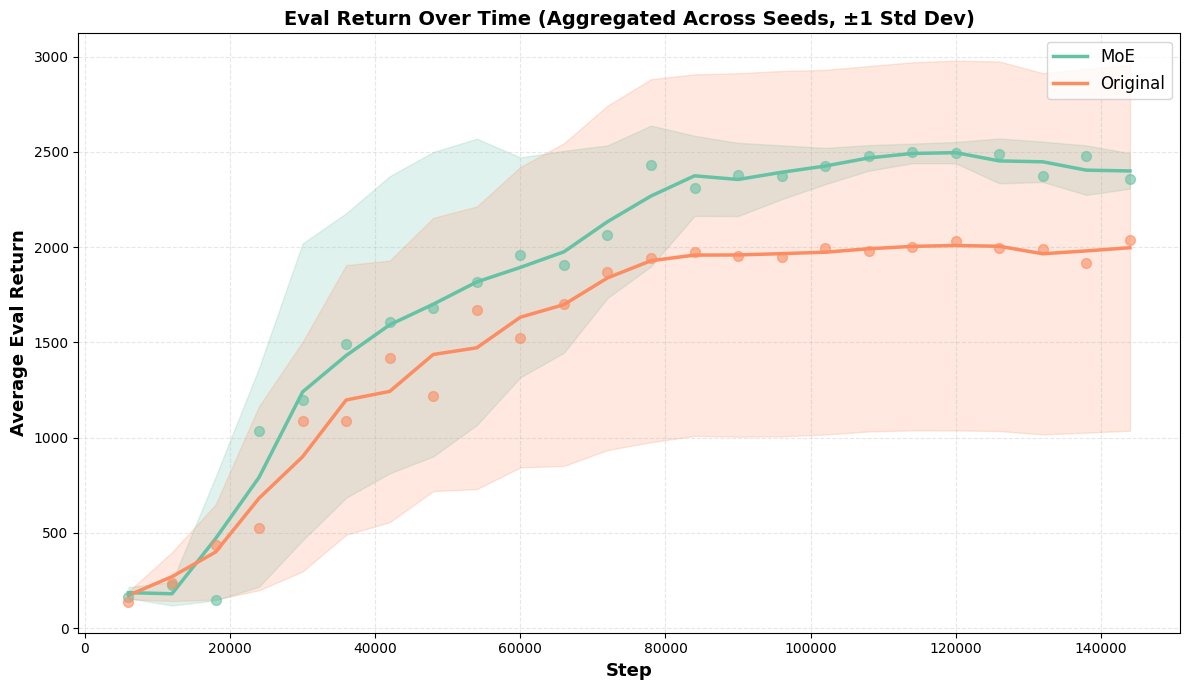

✓ Saved plot: results/individual_seeds_comparison_all_scores.png


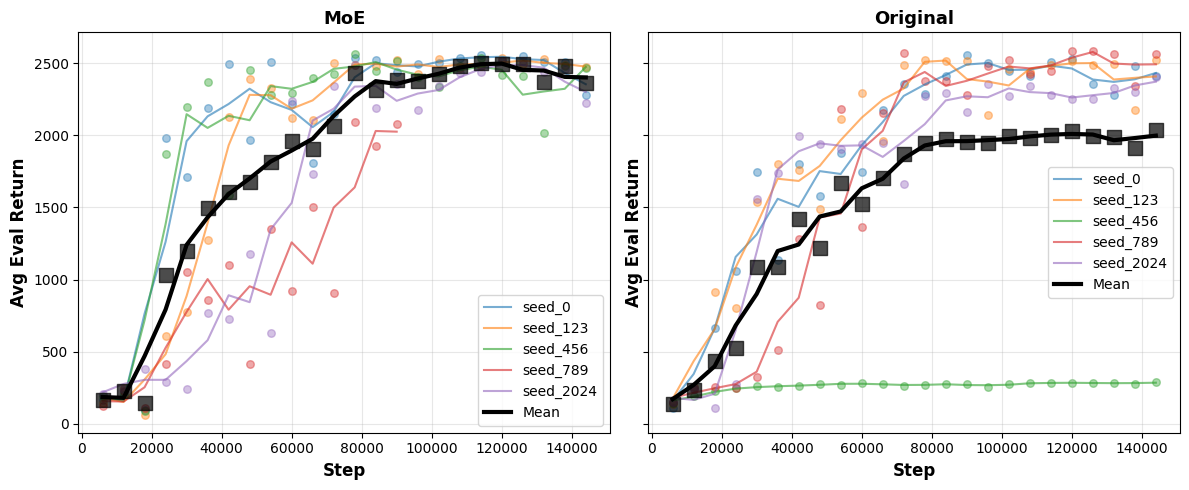

✓ Saved plot: results/cross_seed_eval_success_comparison_all_scores.png


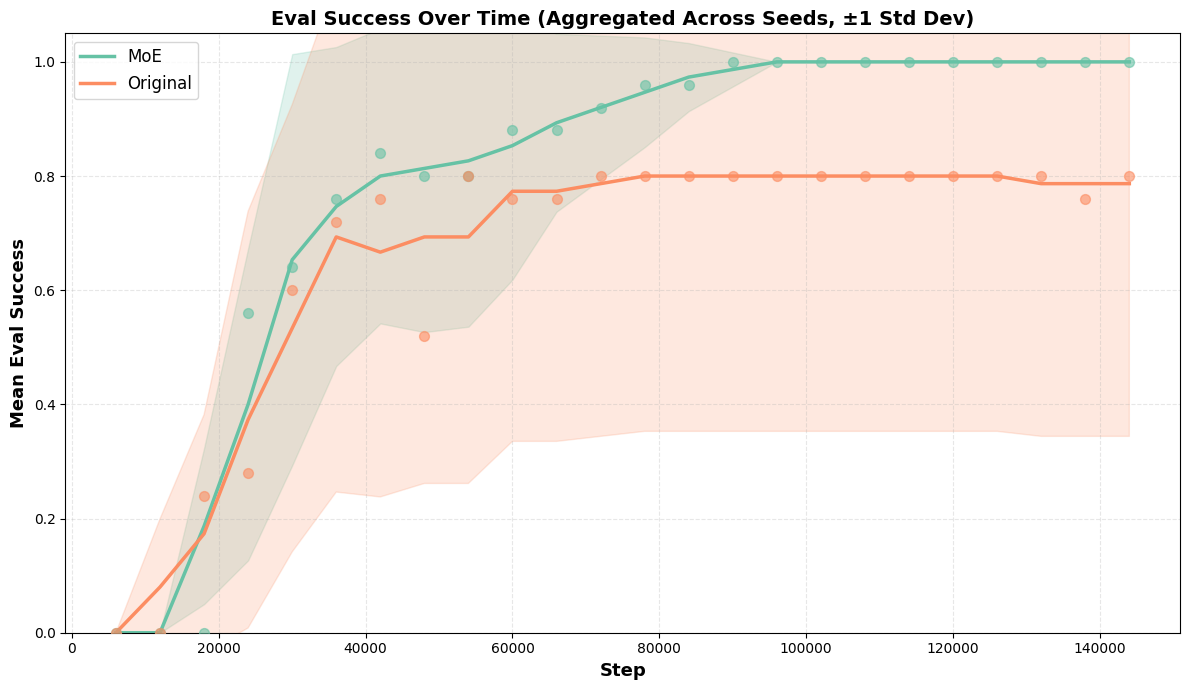

✓ Saved plot: results/individual_seeds_success_comparison_all_scores.png


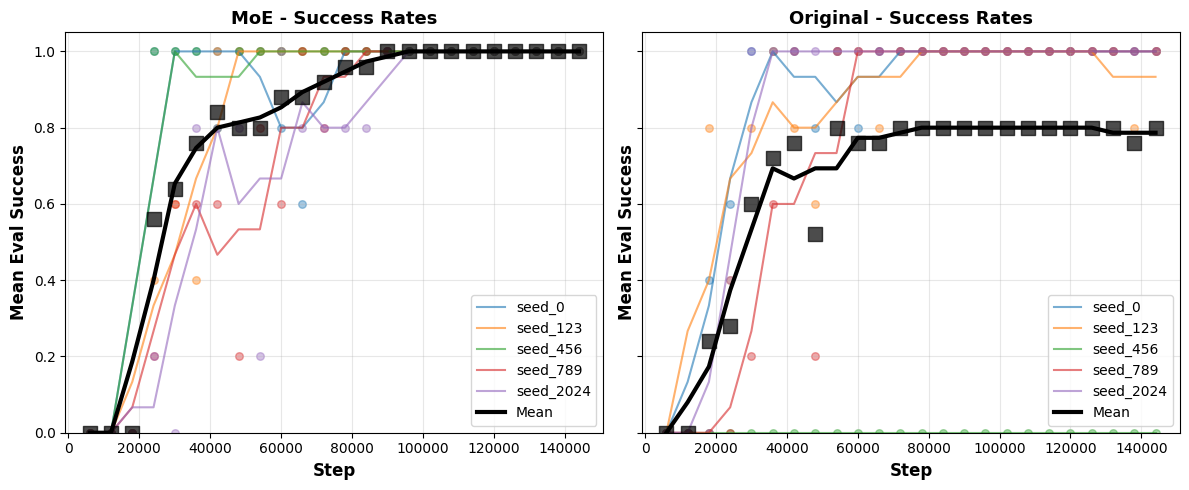

✓ Saved plot: results/variance_trend_eval_return_all_scores.png


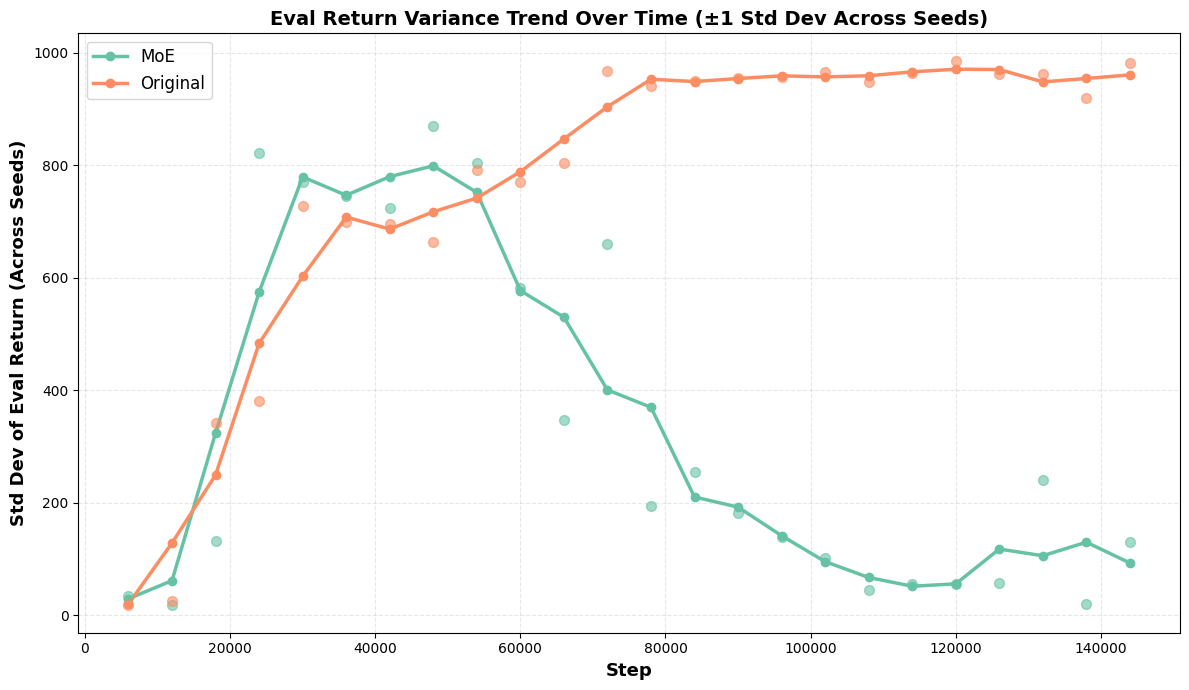

✓ Saved plot: results/variance_trend_eval_success_all_scores.png


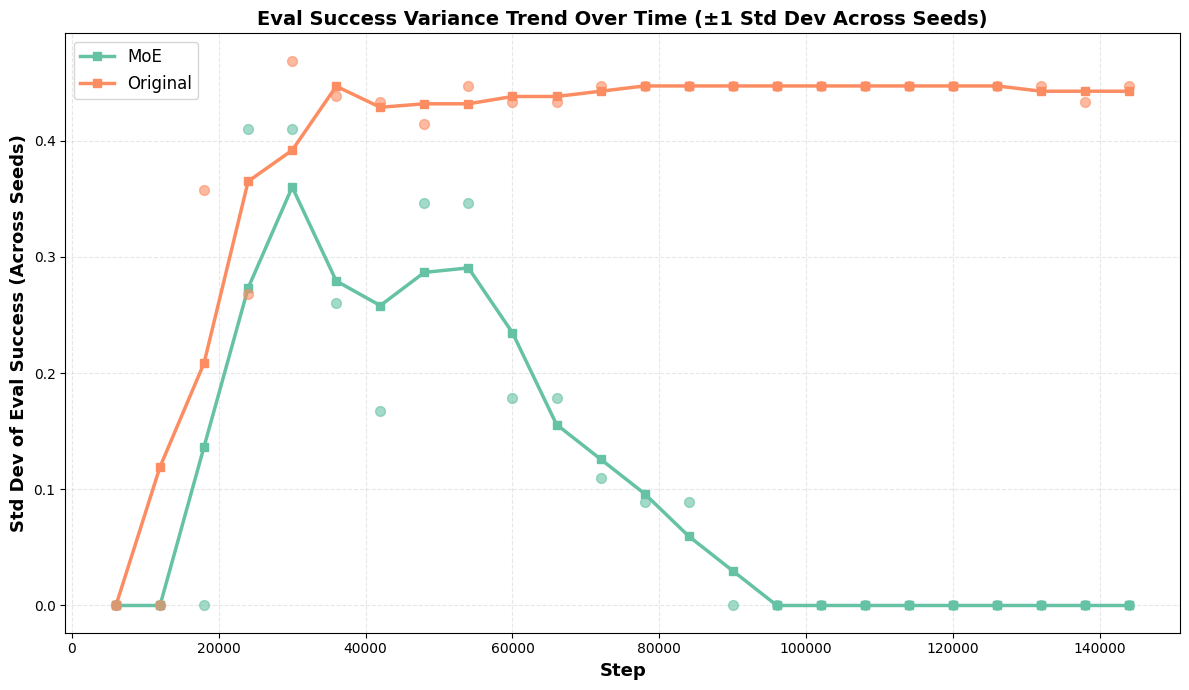

✓ Saved plot: results/variance_trend_combined_all_scores.png


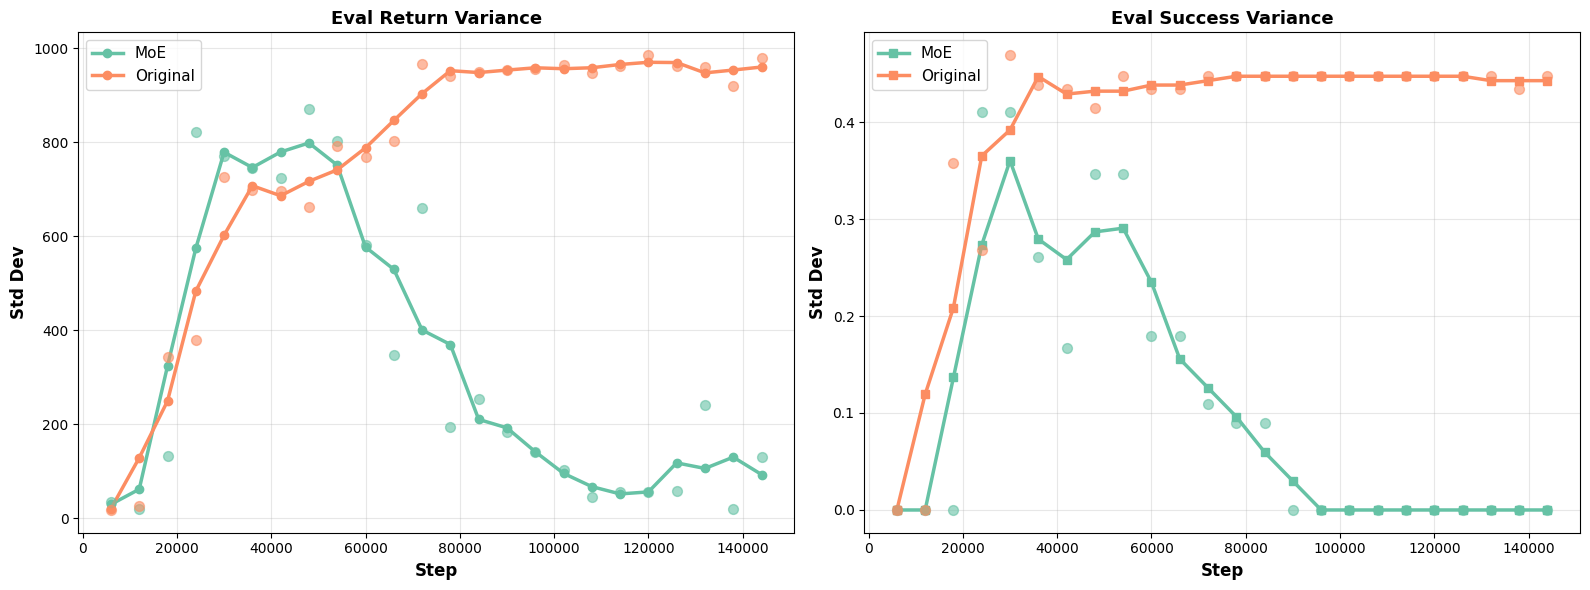


SUMMARY STATISTICS (Aggregated Across Seeds)

MoE:
  - Number of seeds: 5
  - Number of evaluation steps: 24
  - Final mean_eval_return: 2359.7268
  - Final std_eval_return: 129.4312
  - Max mean_eval_return: 2501.8643
  - Min mean_eval_return: 148.5186
  - Overall mean_eval_return: 1849.8978
  - Final mean_eval_success: 1.0000
  - Final std_eval_success: 0.0000
  - Max mean_eval_success: 1.0000
  - Min mean_eval_success: 0.0000
  - Overall mean_eval_success: 0.7917

Original:
  - Number of seeds: 5
  - Number of evaluation steps: 24
  - Final mean_eval_return: 2038.6889
  - Final std_eval_return: 980.6947
  - Max mean_eval_return: 2038.6889
  - Min mean_eval_return: 139.8124
  - Overall mean_eval_return: 1528.6072
  - Final mean_eval_success: 0.8000
  - Final std_eval_success: 0.4472
  - Max mean_eval_success: 0.8000
  - Min mean_eval_success: 0.0000
  - Overall mean_eval_success: 0.6583

✓ All processing complete!


In [21]:
# Define your experiment paths
experiment_paths = {
    'MoE': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/window_close/new_moe/moe_multihead_seed*",
    'Original': "/storage/ssd1/richtsai1103/vid2act/log/metaworld/open3/window_close/new_moe/original_seed*",
}

# Run with all parameters
results = analyze_metrics(
    experiment_paths=experiment_paths,
    output_dir='results',
    smoothness=3,          # 3=minimal, 5=default, 7-9=more, 11+=heavy
    remove_lowest=False    # True to remove lowest score per step
)